In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import utils
import os
from random import randint
import math
from pprint import pprint
from utils import cut # default cut function for seam finding section

In [37]:
def ssd_patch_left(overlap,left_patch,patch_size,sample):
    M = np.zeros(shape=(patch_size,patch_size,3))
    M[:,:overlap,:] = 1
    T = np.zeros(shape=(patch_size,patch_size,3))
    T[:,:overlap,:] = left_patch[:, patch_size-overlap:patch_size,:] #template overlap real values
    T/255.0
    I = sample/255.0
    ssd = ((M*T)**2).sum() - 2 * cv2.filter2D(I, ddepth=-1, kernel = M*T) + cv2.filter2D(I ** 2, ddepth=-1, kernel=M)
    return ssd

In [87]:
def ssd_patch_up(overlap,up_patch,patch_size,sample):
    M = np.zeros(shape=(patch_size,patch_size,3))
    M[:overlap,:,:] = 1
    T = np.zeros(shape=(patch_size,patch_size,3))
    print(T[:overlap,:,:].shape)
    print(up_patch[patch_size-overlap:patch_size, :,:].shape)
    T[:overlap,:,:] = up_patch[patch_size-overlap:patch_size, :,:] #template overlap real values
    T/255.0
    I = sample/255.0
    ssd = ((M*T)**2).sum() - 2 * cv2.filter2D(I, ddepth=-1, kernel = M*T) + cv2.filter2D(I ** 2, ddepth=-1, kernel=M)
    return ssd

In [111]:
def ssd_patch_both(overlap,up_patch,left_patch,patch_size,sample):
    size_x = up_patch.shape[1]
    size_y = left_patch.shape[0] + overlap
    M = np.zeros(shape=(size_y,size_x,3))
    M[:overlap,:overlap,:] = 1
    T = np.zeros(shape=(size_y,size_x,3))
    T[:overlap,:,:] = up_patch #template overlap real values
    T[overlap:,:overlap,:] = left_patch
    T/255.0
    I = sample/255.0
    ssd = ((M*T)**2).sum() - 2 * cv2.filter2D(I, ddepth=-1, kernel = M*T) + cv2.filter2D(I ** 2, ddepth=-1, kernel=M)
    return ssd

In [112]:
def overlap_patch_left(A,B,overlap,patch_size):
    #A is the left patch
    #B is the new patch
    row_size = A.shape[0]
    col_size = A.shape[1]
    s = (A[:,:,:]-B[:,:,:])**2
    s = s[:,:,0] + s[:,:,1] + s[:,:,2]
    s =  s.transpose()
    mask = cut(s)
    mask = mask.transpose()
    output_in = np.zeros(shape=(row_size,overlap,3))
    row = 0
    col = 0
    for x in mask:
        col = 0
        for y in x:
            if y == 0:
                output_in[row,col,:] = A[row,col,:]
            else:
                output_in[row,col,:] = B[row,col,:]
            #print(row,col)
            col += 1
        row += 1
    return output_in

In [113]:
def overlap_patch_up(A,B,overlap,patch_size):
    #A is the up patch
    #B is the new patch          
    row_size = A.shape[0]
    col_size = A.shape[1]
    s = (A[:,:,:]-B[:,:,:])**2
    s = s[:,:,0] + s[:,:,1] + s[:,:,2]
    mask = cut(s)
    output_in = np.zeros(shape=(overlap,col_size,3))
    row = 0
    col = 0
    for x in mask:
        col = 0
        for y in x:
            if y == 0:
                output_in[row,col,:] = A[row,col,:]
            else:
                output_in[row,col,:] = B[row,col,:]
            #print(row,col)
            col += 1
        row += 1
    return output_in

In [166]:
def choose_sample(k,ssd,patch_size,input_image):
    input_image_size_r = input_image.shape[0]
    input_image_size_c = input_image.shape[1]
    
    #print(input_image_size)
    row = []
    col = []
    z = []
    ssd_test = ssd
    while len(row) < k:
        row_1, col_1 = np.where(ssd_test == np.amin(ssd_test))
        if (patch_size-1)/2<row_1[0] < input_image_size_r-((patch_size-1)/2) and (patch_size-1)/2<col_1[0] < input_image_size_c-((patch_size-1)/2):
            row.append(row_1[0])
            col.append(col_1[0])
        ssd_test[row_1,col_1] = 1000000000
    #print (row, col, z)
    rand_int = randint(0,k-1)
    return input_image[row[rand_int]-int(((patch_size-1)/2)):(row[rand_int]-int((patch_size-1)/2))+patch_size,col[rand_int]-int((patch_size-1)/2):(col[rand_int]-int((patch_size-1)/2))+patch_size,:]

In [167]:
def ssd_transfer(patch_size,sample,target):
    target = cv2.cvtColor(target,cv2.COLOR_RGB2GRAY)
    sample_1 = cv2.cvtColor(sample,cv2.COLOR_RGB2GRAY)
    target = cv2.GaussianBlur(target,(5,5),3)
    sample_1 = cv2.GaussianBlur(sample_1,(5,5),3)
    
    M = np.ones(shape=(patch_size,patch_size))
    T = np.zeros(shape=(patch_size,patch_size))
    T[:,:] = target[:patch_size,:patch_size]
    T/255.0
    I = sample_1/255.0
    
    ssd = ((M*T)**2).sum() - 2 * cv2.filter2D(I, ddepth=-1, kernel = M*T) + cv2.filter2D(I ** 2, ddepth=-1, kernel=M)
    
    return ssd

In [169]:
def ssd_transfer_up(patch_size,sample,target,overlap,x,y, row_size):
    target = cv2.cvtColor(target,cv2.COLOR_RGB2GRAY)
    sample_1 = cv2.cvtColor(sample,cv2.COLOR_RGB2GRAY)
    target = cv2.GaussianBlur(target,(5,5),3)
    sample_1 = cv2.GaussianBlur(sample_1,(5,5),3)
    if row_size - y < patch_size-overlap:
        M = np.ones(shape=(row_size-y,patch_size))
        T = np.zeros(shape=(row_size-y,patch_size))
        T[:,:] = target[y:row_size,x:x+patch_size]
        T/255.0
        I = sample_1/255.0
    else:
        M = np.ones(shape=(patch_size,patch_size))
        T = np.zeros(shape=(patch_size,patch_size))
        T[:,:] = target[y:y+patch_size,x:x+patch_size]
        T/255.0
        I = sample_1/255.0
    ssd = ((M*T)**2).sum() - 2 * cv2.filter2D(I, ddepth=-1, kernel = M*T) + cv2.filter2D(I ** 2, ddepth=-1, kernel=M)
    
    return ssd

In [170]:
def ssd_transfer_both(patch_size,sample,target,overlap,x,y, row_size,col_size):
    target = cv2.cvtColor(target,cv2.COLOR_RGB2GRAY)
    sample_1 = cv2.cvtColor(sample,cv2.COLOR_RGB2GRAY)
    target = cv2.GaussianBlur(target,(5,5),3)
    sample_1 = cv2.GaussianBlur(sample_1,(5,5),3)
    if row_size - y < patch_size-overlap:
        M = np.ones(shape=(row_size-y,patch_size))
        T = np.zeros(shape=(row_size-y,patch_size))
        T[:,:] = target[y:row_size,x:x+patch_size]
        T/255.0
        I = sample_1/255.0
    else:
        M = np.ones(shape=(patch_size-overlap,patch_size-overlap))
        T = np.zeros(shape=(patch_size-overlap,patch_size-overlap))
        T[:,:] = target[y:y+patch_size-overlap,x:x+patch_size-overlap]
        T/255.0
        I = sample_1/255.0
    ssd = ((M*T)**2).sum() - 2 * cv2.filter2D(I, ddepth=-1, kernel = M*T) + cv2.filter2D(I ** 2, ddepth=-1, kernel=M)
    
    return ssd

In [176]:
def ssd_transfer_left(patch_size,sample,target,overlap,x,y, col_size):
    target = cv2.cvtColor(target,cv2.COLOR_RGB2GRAY)
    sample_1 = cv2.cvtColor(sample,cv2.COLOR_RGB2GRAY)
    target = cv2.GaussianBlur(target,(5,5),3)
    sample_1 = cv2.GaussianBlur(sample_1,(5,5),3)
    if col_size - x < patch_size-overlap:
        M = np.ones(shape=(patch_size,col_size -x))
        T = np.zeros(shape=(patch_size,col_size -x))
        T[:,:] = target[y:patch_size,x:col_size]
        T/255.0
        I = sample_1/255.0
    else:
        M = np.zeros(shape=(patch_size,patch_size))
        M[:,:overlap] = 1
        T = np.zeros(shape=(patch_size,patch_size))
        T[:,:] = target[y:patch_size,x:x+patch_size]
        T/255.0
        I = sample_1/255.0
    ssd = ((M*T)**2).sum() - 2 * cv2.filter2D(I, ddepth=-1, kernel = M*T) + cv2.filter2D(I ** 2, ddepth=-1, kernel=M)
    
    return ssd

In [179]:
def texture_transfer(sample,target,patch_size,overlap,alpha,k):
    """
    Feel free to add function parameters
    """
    #output = np.zeros(shape=(target.shape[0],target.shape[1],3))
    row_size = target.shape[0]
    col_size = target.shape[1]
    y = 0 #the current row value
    while y < target.shape[0]:
        x = 0 #current column value 
        while x < target.shape[1]:
            if y == 0 and x == 0: #1
                ssd = ssd_transfer(patch_size,sample,target)
                out = choose_sample(k,ssd,patch_size,sample)
                target[y:patch_size,x:patch_size,:] = out
                x += patch_size
                print(y,x)
            elif y ==0 and x + patch_size - overlap <= col_size: #2
                left_patch = target[y:patch_size,x-patch_size:x,:]
                
                ssd_overlap = ssd_patch_left(overlap,left_patch,patch_size,sample)
                ssd_transfer_array = ssd_transfer_left(patch_size,sample,target,overlap,x,y,col_size)

                ssd = (ssd_overlap[:,:,0] + ssd_overlap[:,:,1] + ssd_overlap[:,:,2])*alpha + ssd_transfer_array*(1-alpha)
                out = choose_sample(k,ssd,patch_size,sample)
                
                
                #left 
                A = left_patch[:,patch_size-overlap:,:] 
                B = out[:,:overlap,:]
                left = overlap_patch_left(A,B,overlap,patch_size)
                target[y:patch_size,x-overlap:x,:] = left
                
                #left over
                target[y:patch_size,x:x+patch_size-overlap,:] = out[:,overlap:,:]
                x = x + patch_size - overlap
                print(y,x)
                
            else:
                return target

0 11
0 19
0 27
0 35
0 43
0 51
0 59
0 67
0 75
0 83
0 91
0 99
0 107
0 115
0 123
0 131
0 139
0 147
0 155
0 163
0 171
0 179
0 187
0 195
0 203
0 211
0 219
0 227
0 235
0 243
0 251
0 259
0 267


C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


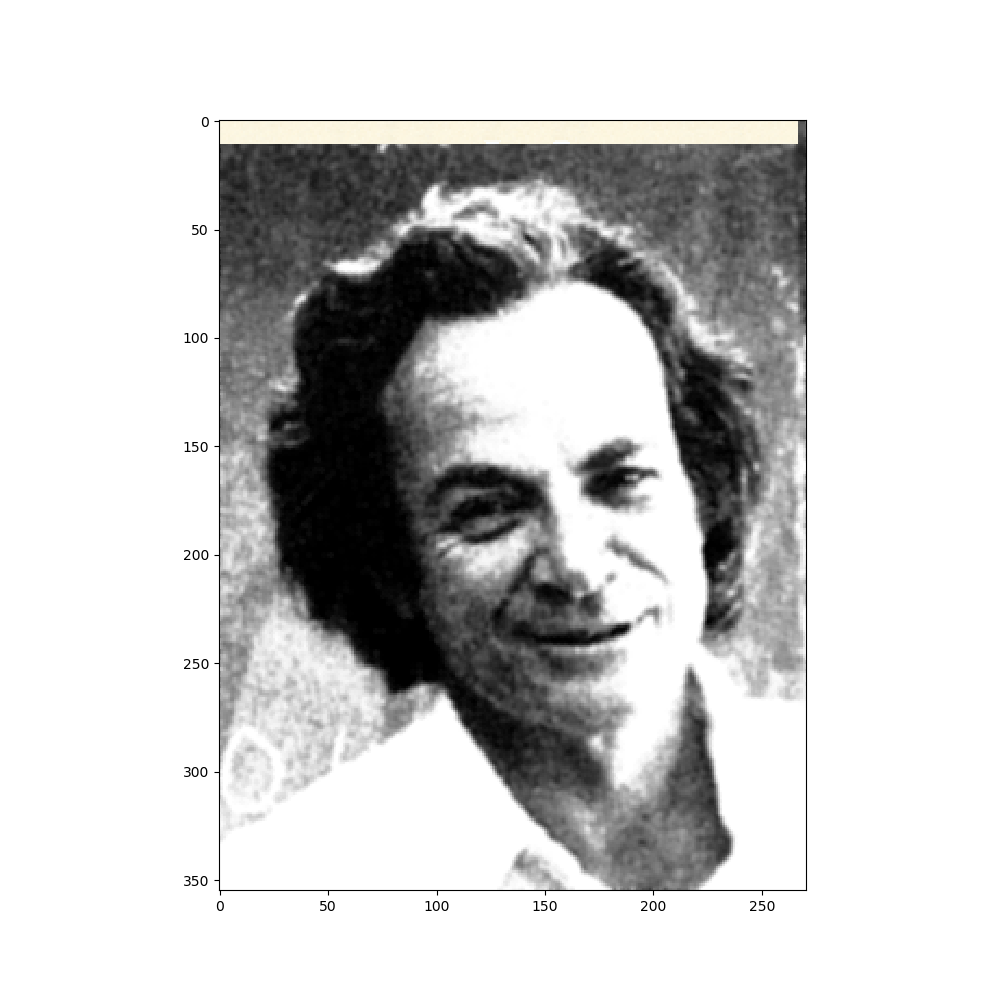

In [187]:
target_dir = 'samples/feynman.tiff'
sample_dir = 'samples/sketch.tiff'
if os.path.exists(sample_dir):
    sample = cv2.imread(sample_dir)
    sample = cv2.cvtColor(sample,cv2.COLOR_BGR2RGB)
    target = cv2.imread(target_dir)
    target = cv2.cvtColor(target,cv2.COLOR_BGR2RGB)

output = texture_transfer(sample, target,11,3,.1,100)
output = output.astype('uint8')
fig, axes = plt.subplots(1, 1)
fig.set_size_inches(10, 10)
axes.imshow(output)

In [181]:
def ssd_transfer_test(patch_size,sample,target):
    target = cv2.cvtColor(target,cv2.COLOR_RGB2GRAY)
    sample_1 = cv2.cvtColor(sample,cv2.COLOR_RGB2GRAY)
    target = cv2.GaussianBlur(target,(5,5),3)
    sample_1 = cv2.GaussianBlur(sample_1,(5,5),3)
    
    M = np.ones(shape=(patch_size,patch_size))
    T = np.zeros(shape=(patch_size,patch_size))
    T[:,:] = target[:patch_size,:patch_size]
    T/255.0
    I = sample_1/255.0
    
    ssd = ((M*T)**2).sum() - 2 * cv2.filter2D(I, ddepth=-1, kernel = M*T) + cv2.filter2D(I ** 2, ddepth=-1, kernel=M)
    
    return ssd

In [141]:
ssd = ssd_transfer_test(51,sample,target)

In [148]:
def choose_sample_test(k,ssd,patch_size,input_image):
    input_image_size_r = input_image.shape[0]
    input_image_size_c = input_image.shape[1]
    
    #print(input_image_size)
    row = []
    col = []
    z = []
    ssd_test = ssd
    t = 0
    while len(row) < k:
        row_1, col_1 = np.where(ssd_test == np.amax(ssd_test))
        if (patch_size-1)/2<row_1[0] < input_image_size_r-((patch_size-1)/2) and (patch_size-1)/2<col_1[0] < input_image_size_c-((patch_size-1)/2):
            row.append(row_1[0])
            col.append(col_1[0])
            image = input_image[row_1[0]-int(((patch_size-1)/2)):(row_1[0]-int((patch_size-1)/2))+patch_size,col_1[0]-int((patch_size-1)/2):(col_1[0]-int((patch_size-1)/2))+patch_size,:]
            image = image.astype('uint8')
            fig, axes = plt.subplots(1, 1)
            fig.set_size_inches(10, 10)
            axes.imshow(image)
            plt.savefig(str(t)+'.png')
            t += 1
            
        ssd_test[row_1,col_1] = 0
            
    #print (row, col, z)
    rand_int = randint(0,k-1)
    return input_image[row[rand_int]-int(((patch_size-1)/2)):(row[rand_int]-int((patch_size-1)/2))+patch_size,col[rand_int]-int((patch_size-1)/2):(col[rand_int]-int((patch_size-1)/2))+patch_size,:]

<IPython.core.display.Javascript object>


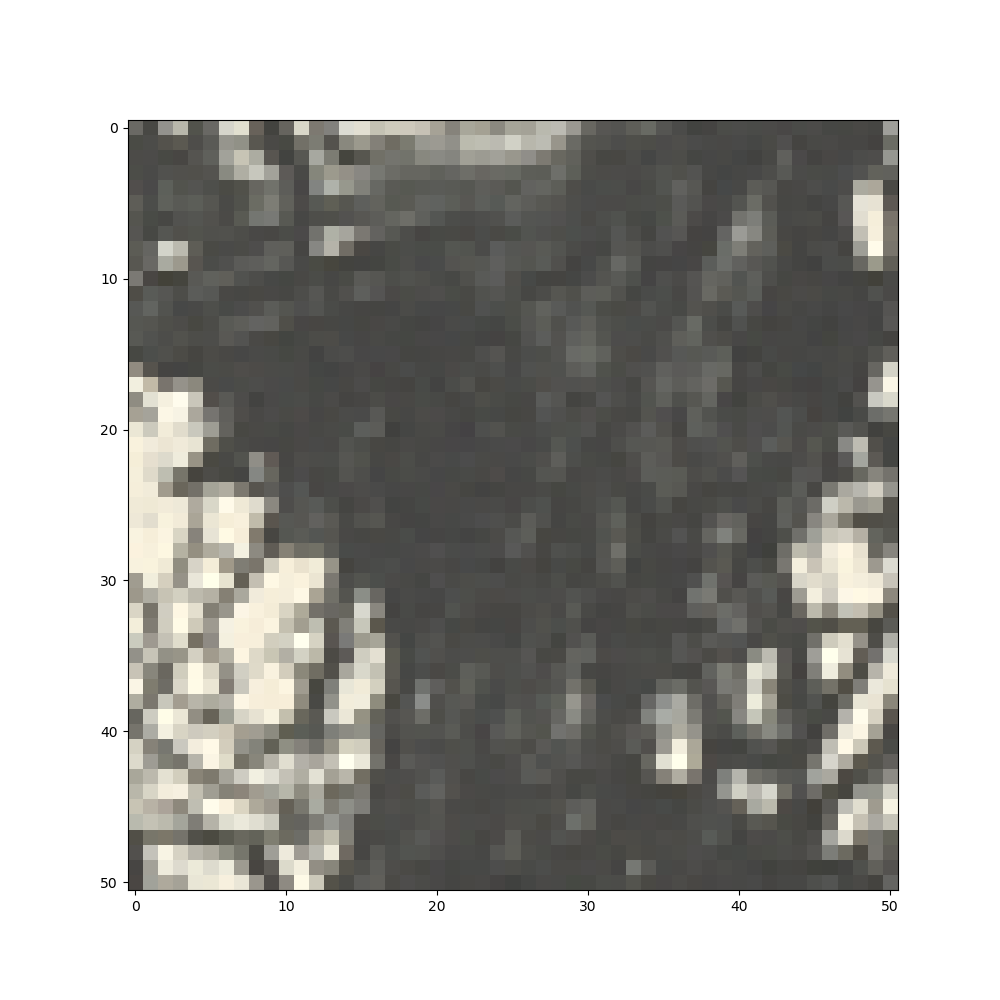

<IPython.core.display.Javascript object>


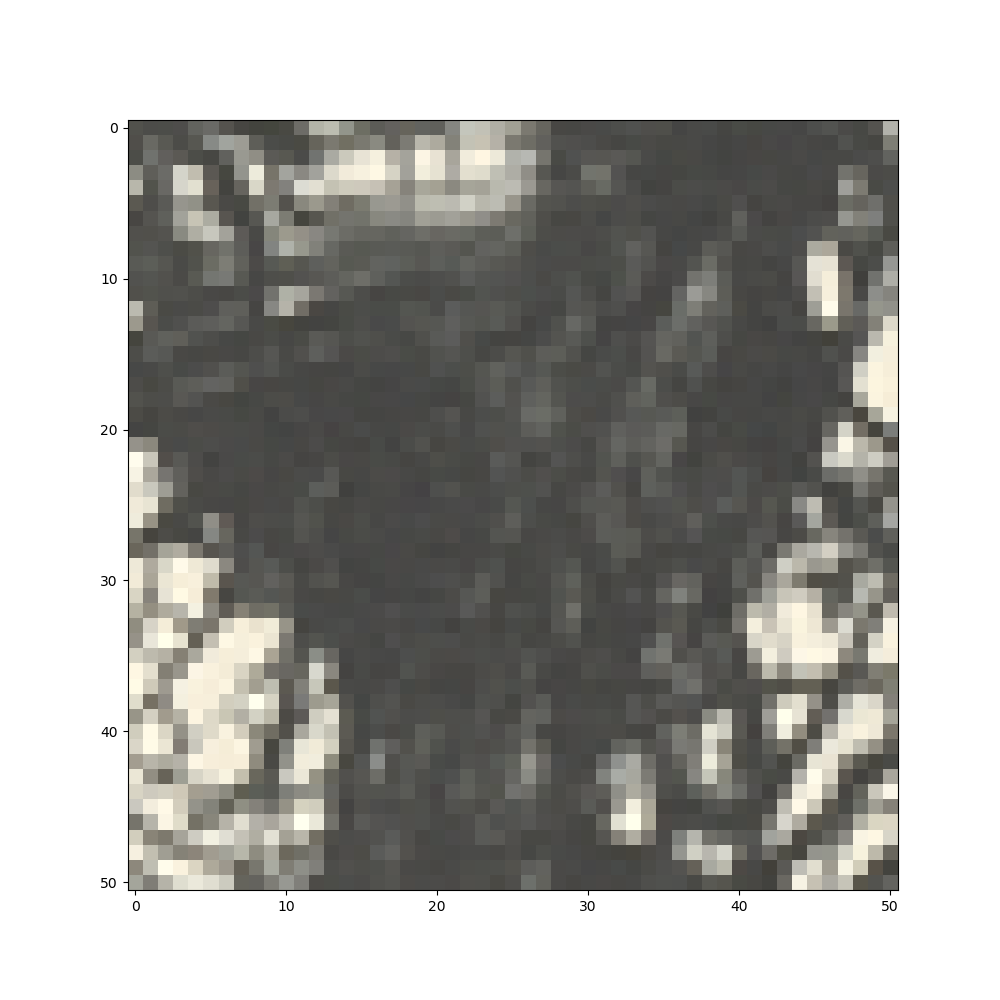

<IPython.core.display.Javascript object>


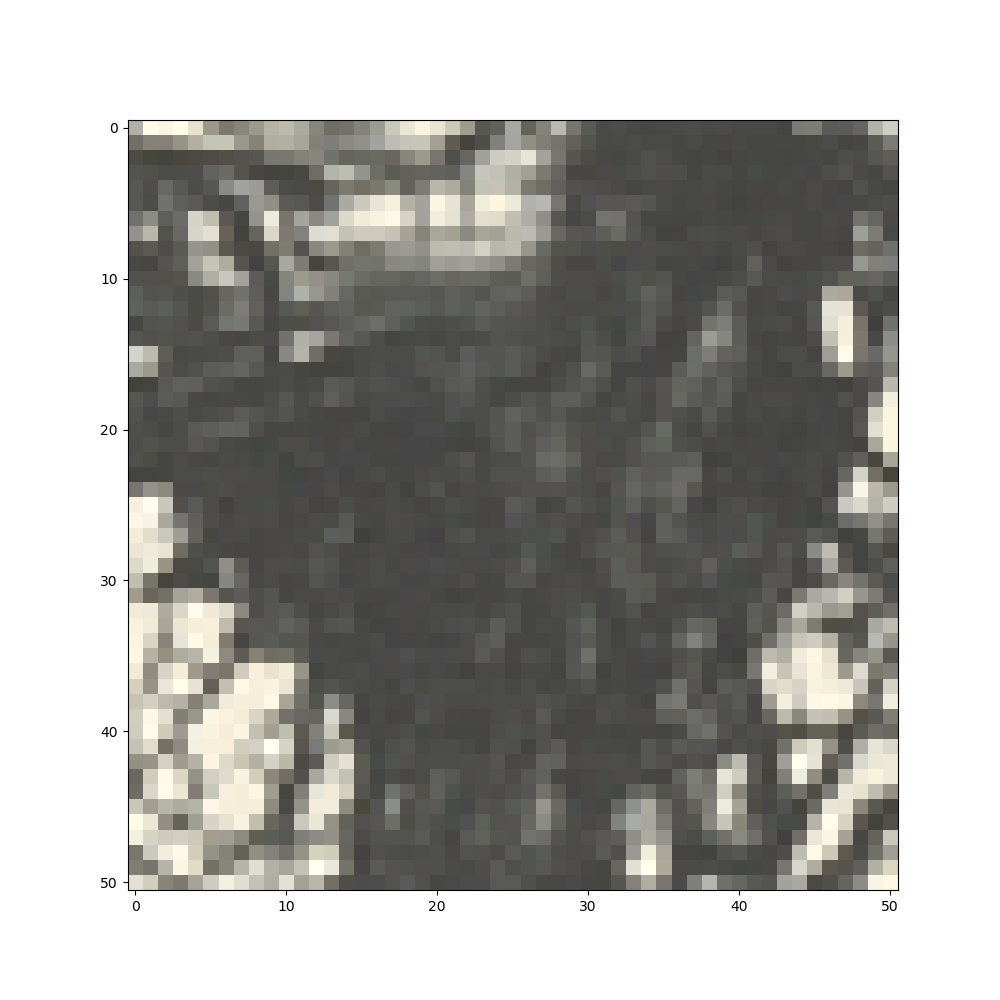

<IPython.core.display.Javascript object>


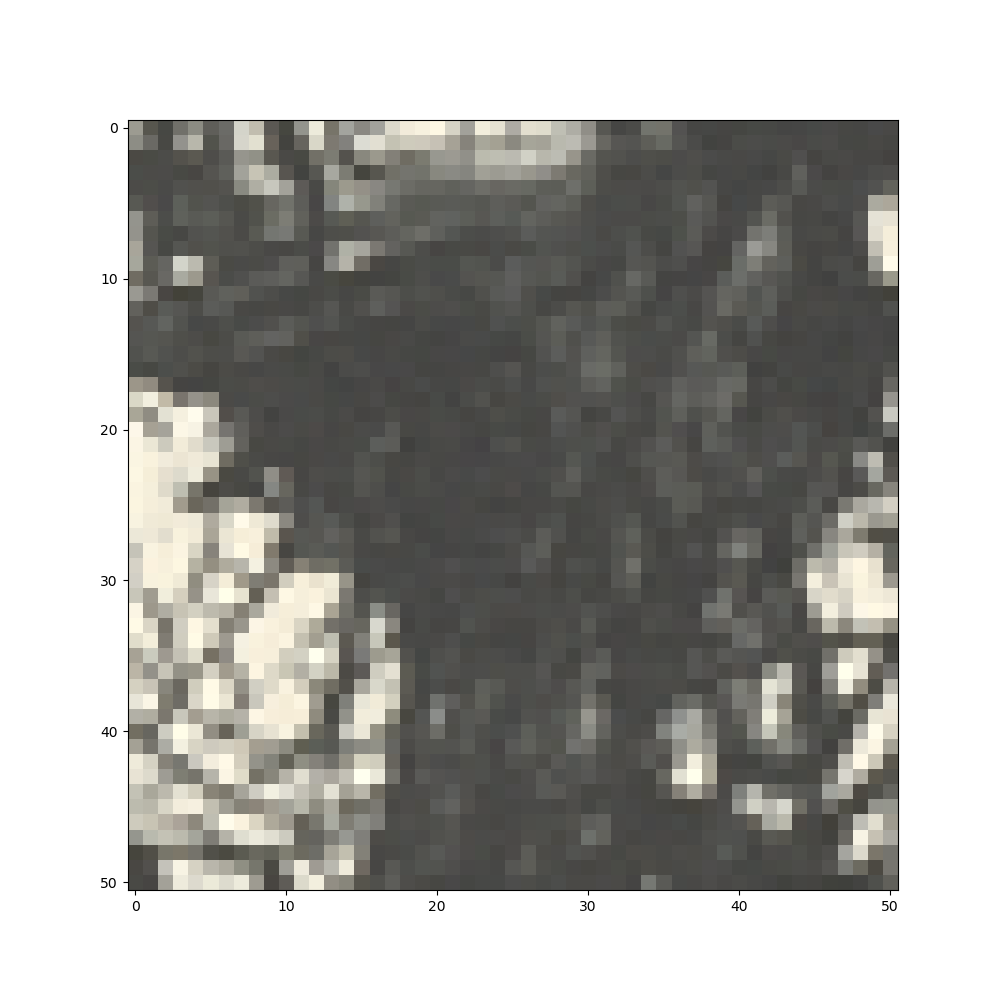

<IPython.core.display.Javascript object>


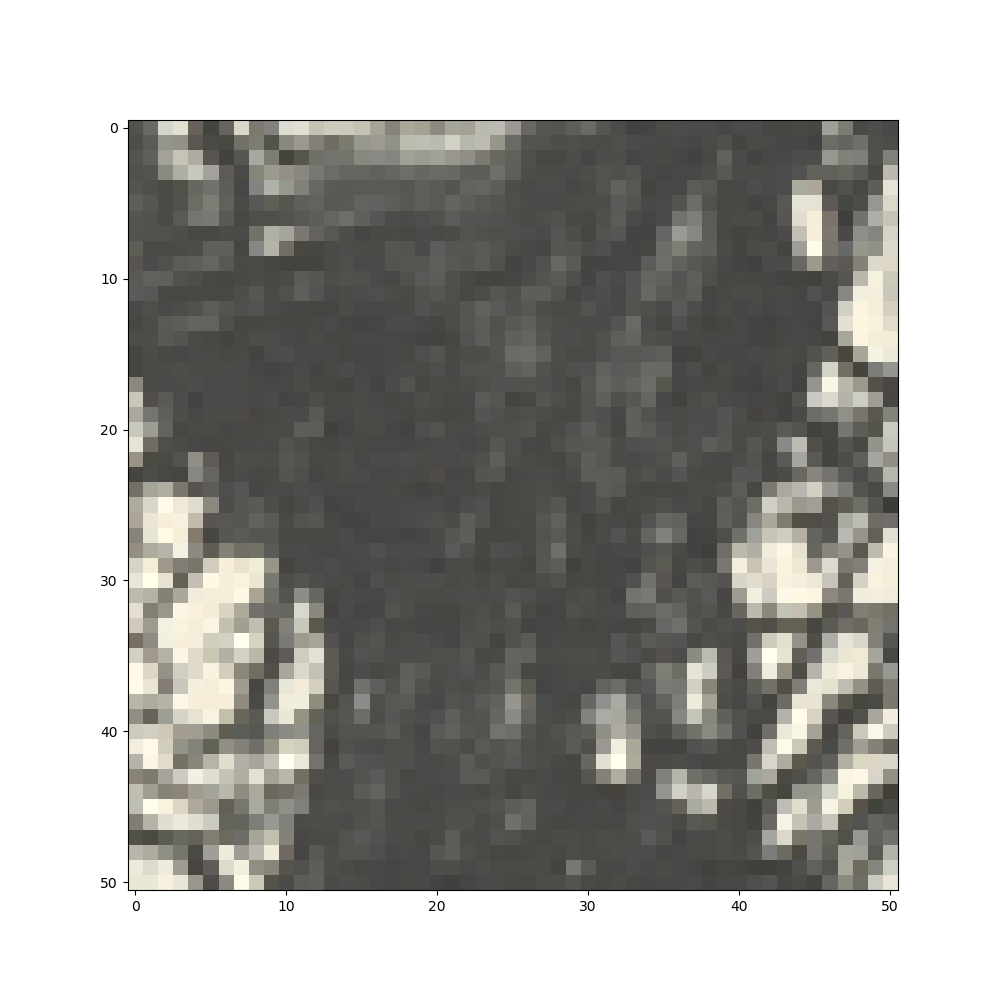

<IPython.core.display.Javascript object>


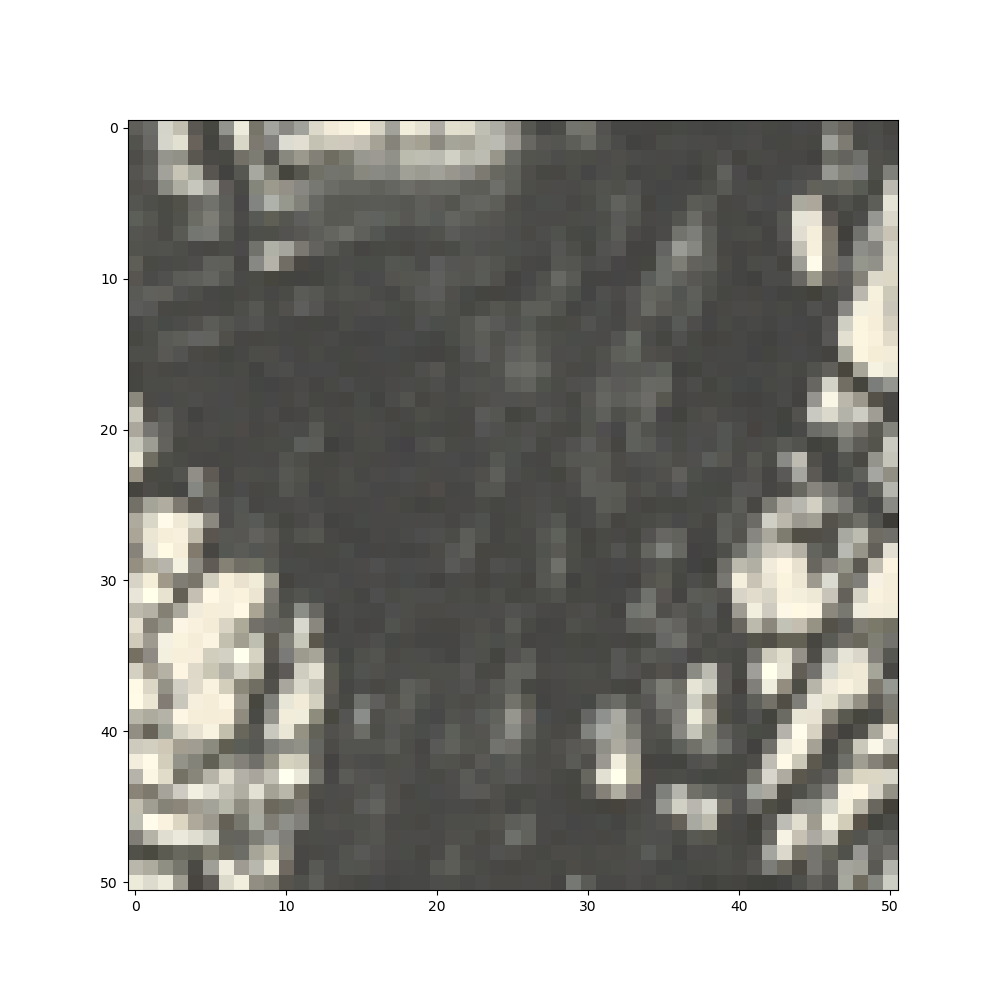

<IPython.core.display.Javascript object>


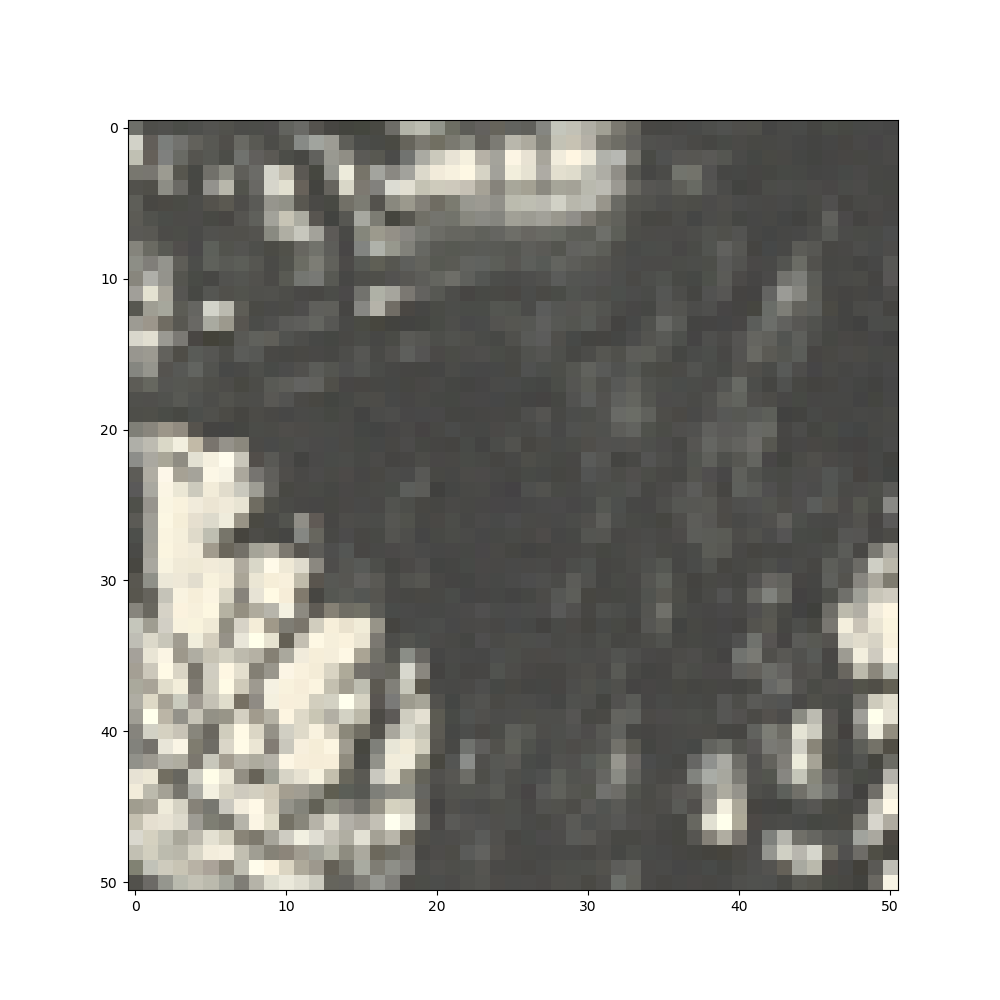

<IPython.core.display.Javascript object>


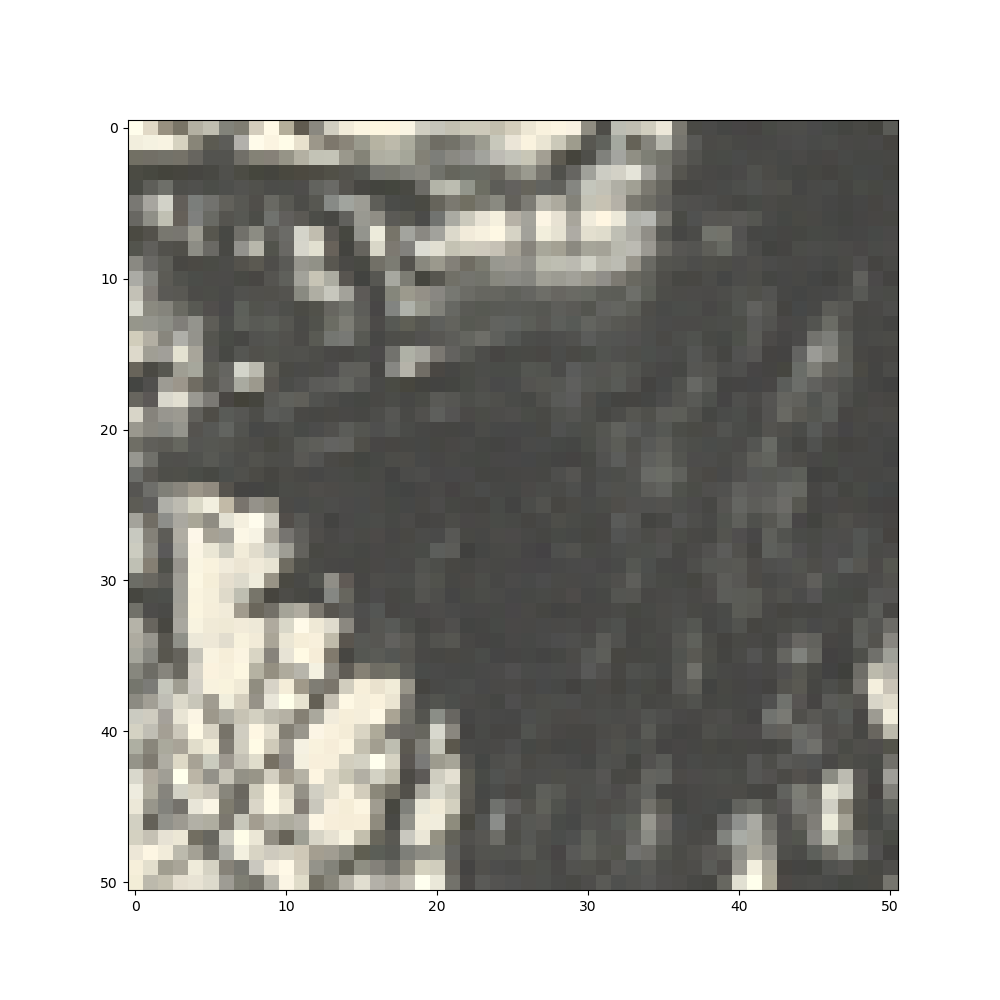

<IPython.core.display.Javascript object>


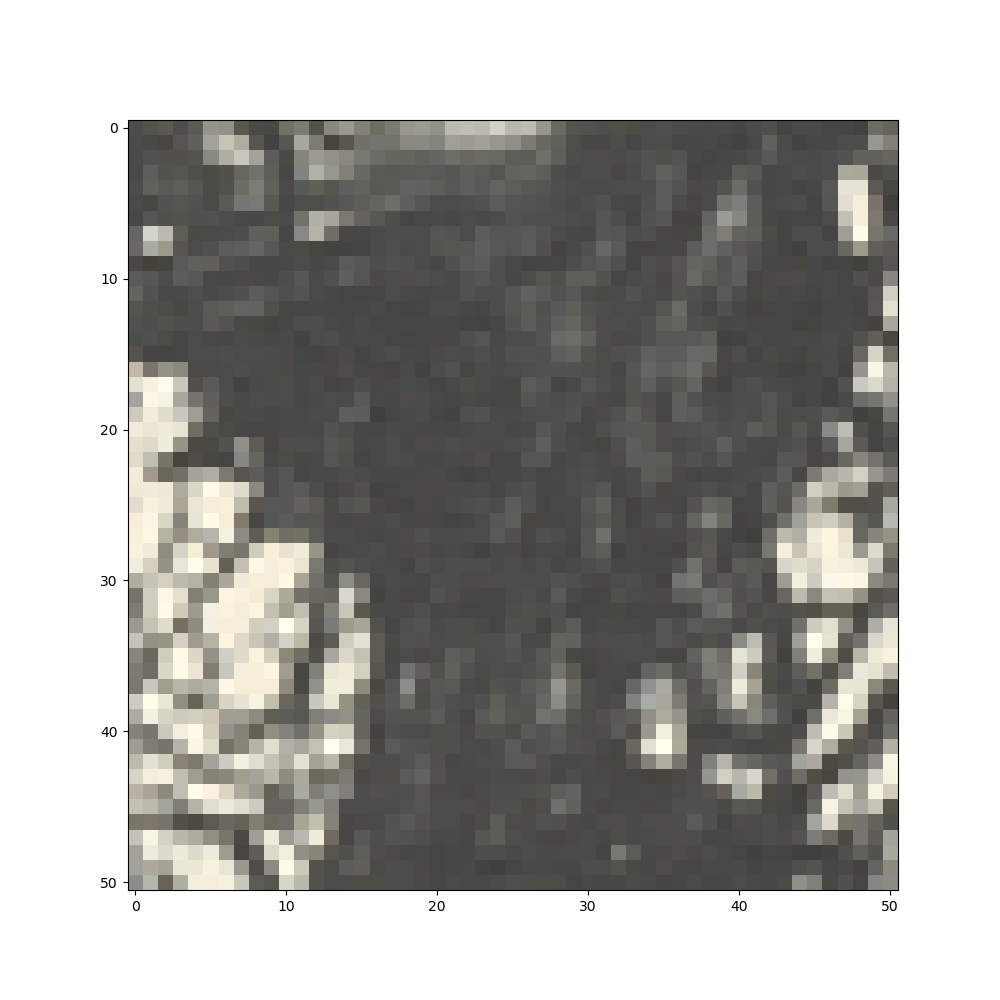

<IPython.core.display.Javascript object>


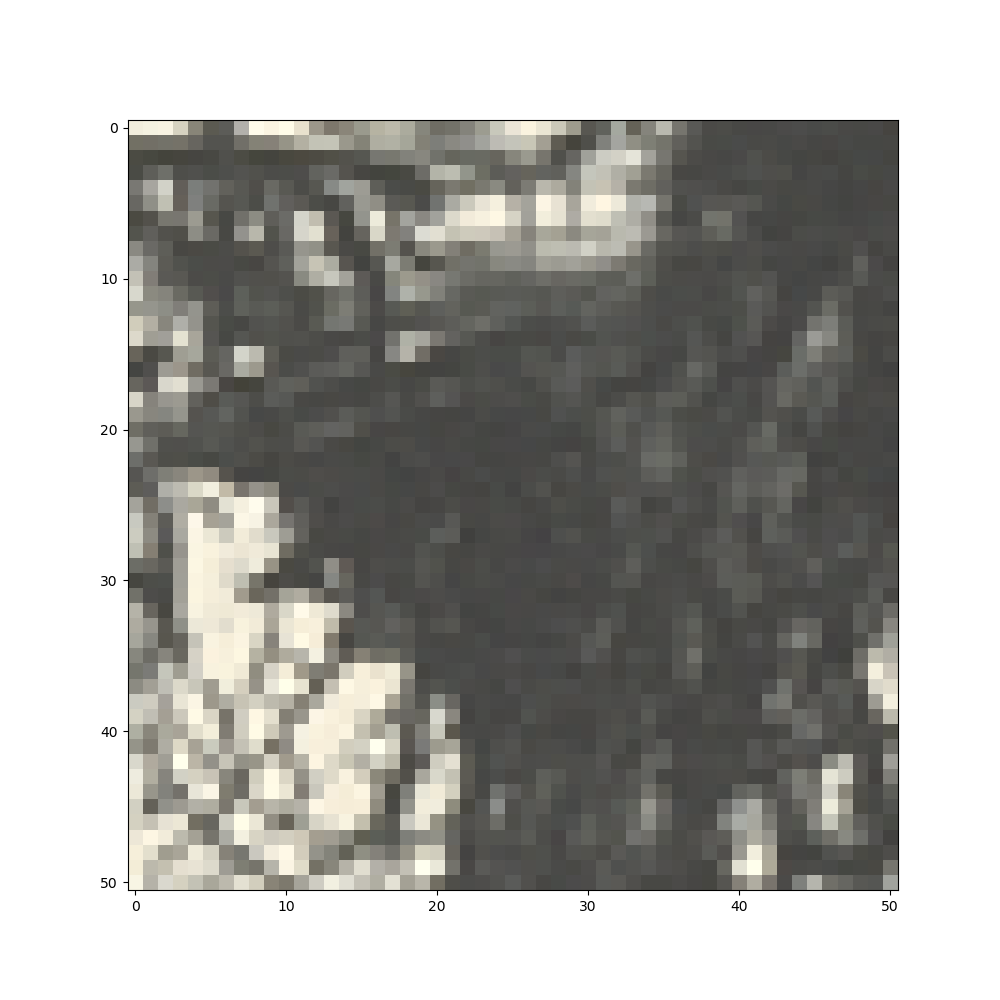

<IPython.core.display.Javascript object>


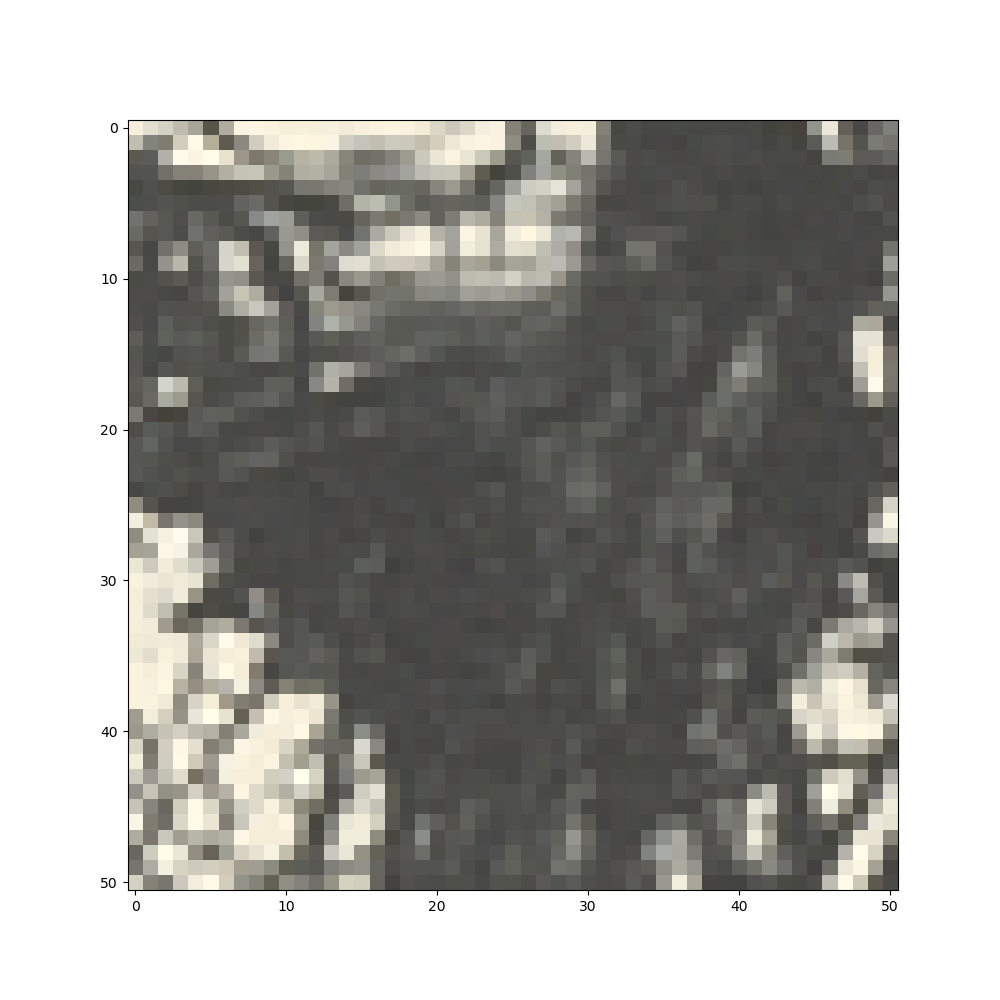

<IPython.core.display.Javascript object>


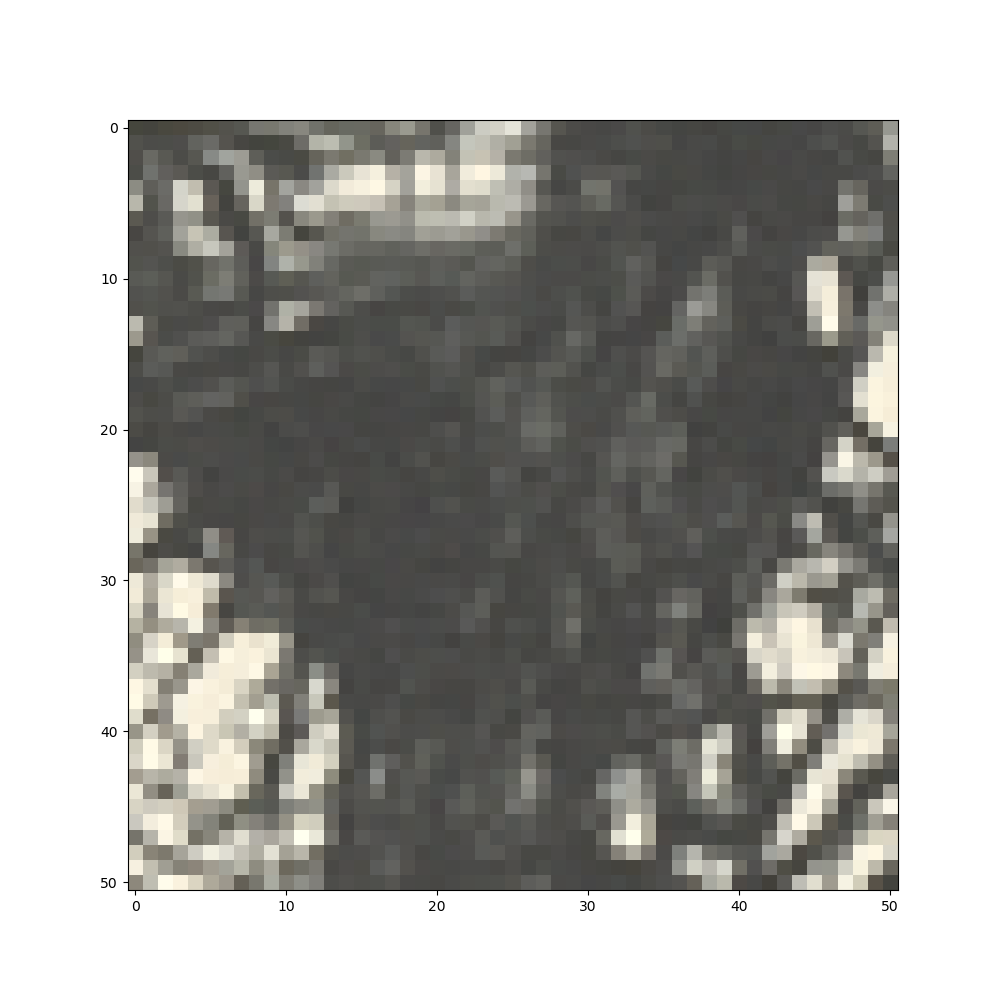

<IPython.core.display.Javascript object>


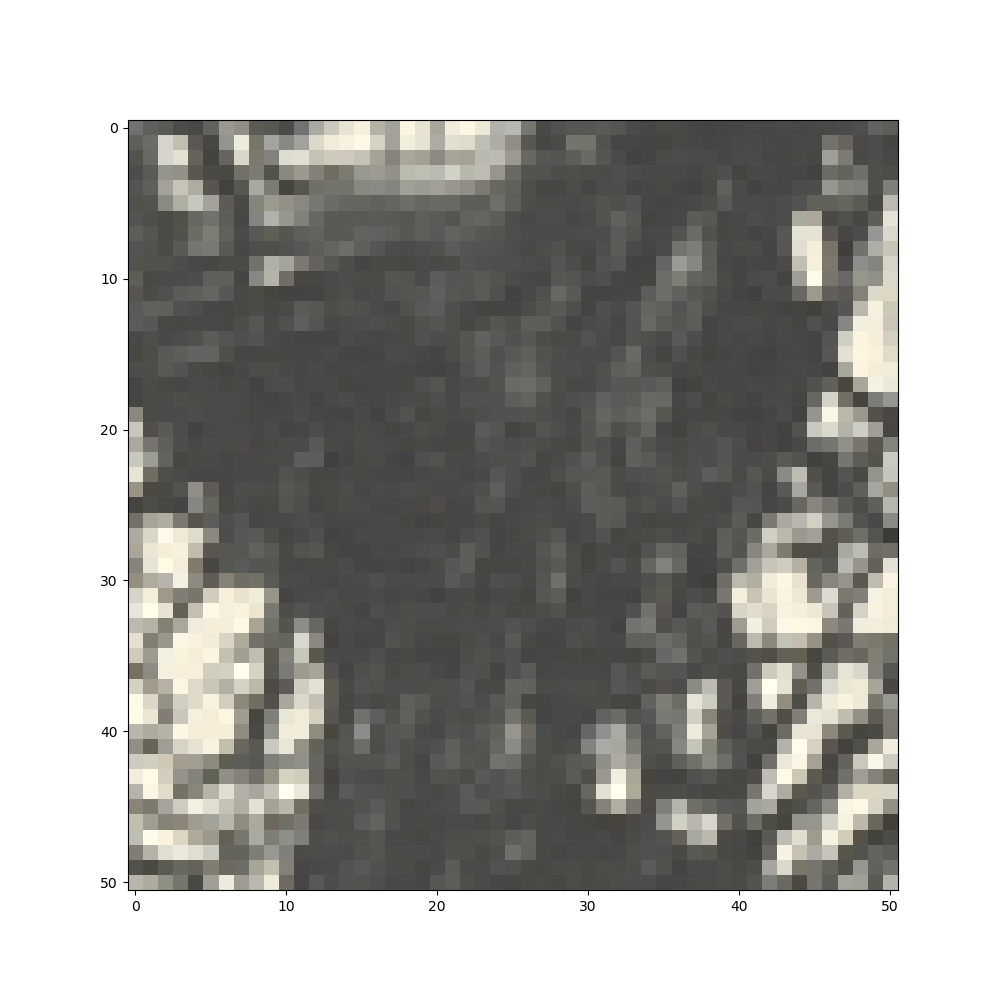

<IPython.core.display.Javascript object>


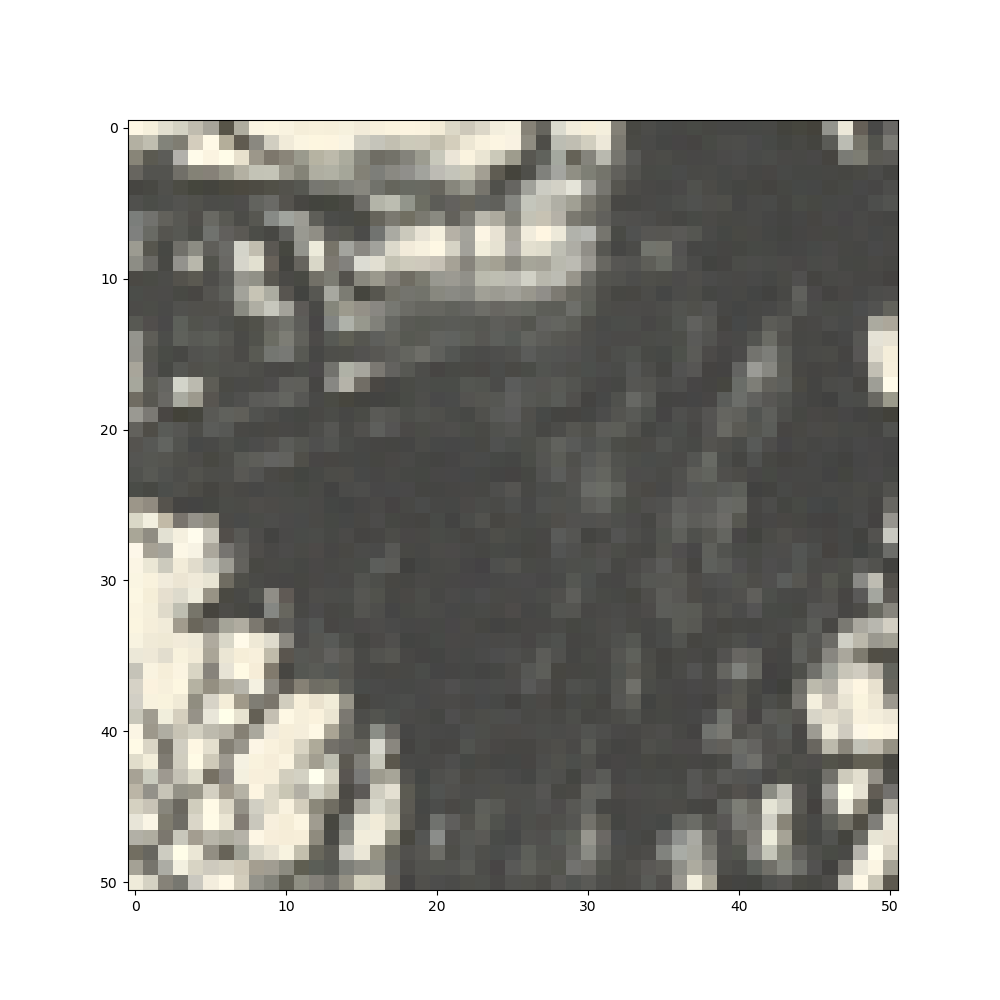

<IPython.core.display.Javascript object>


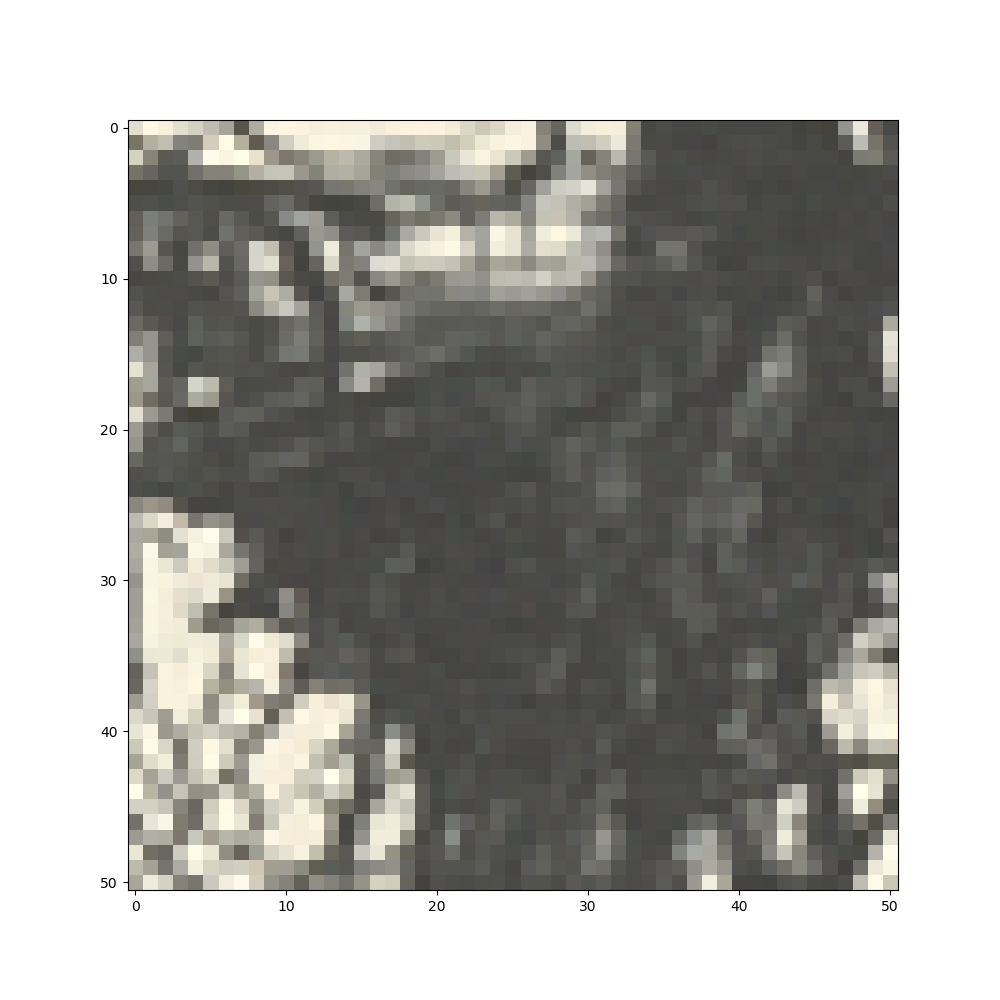

<IPython.core.display.Javascript object>


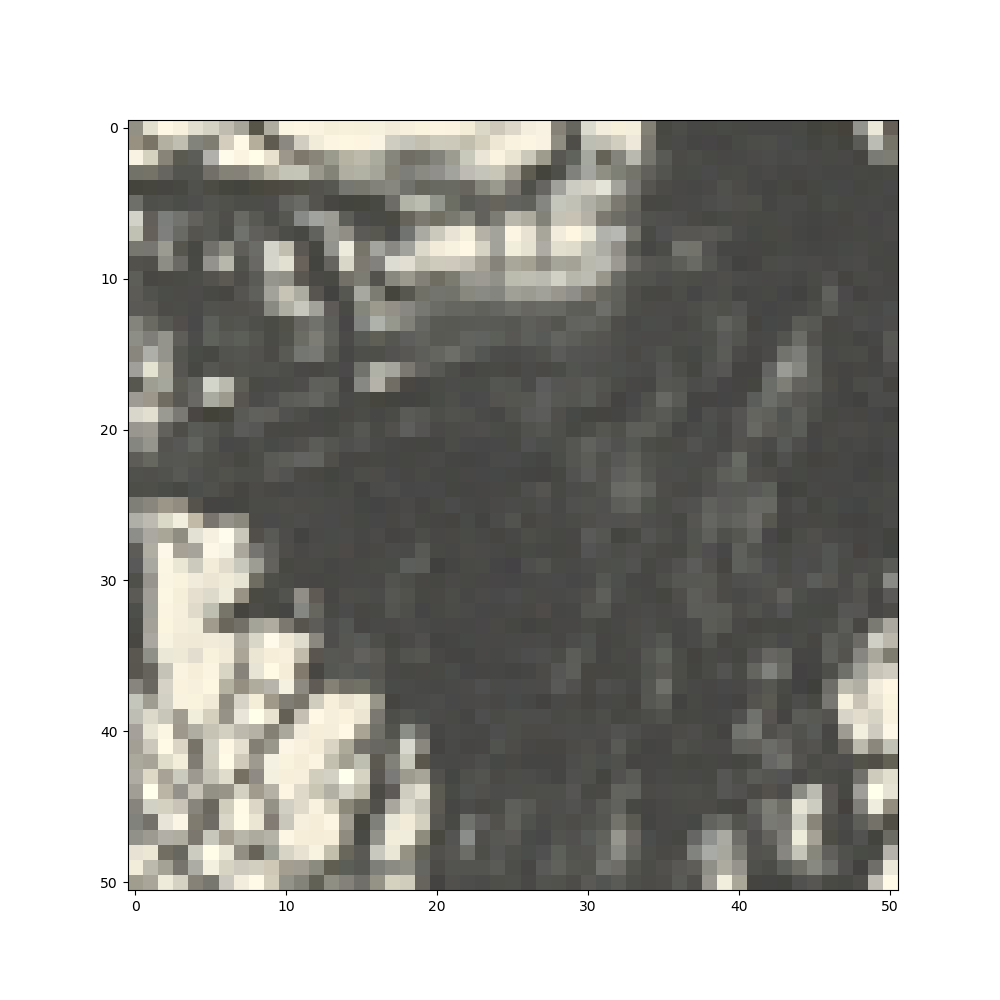

<IPython.core.display.Javascript object>


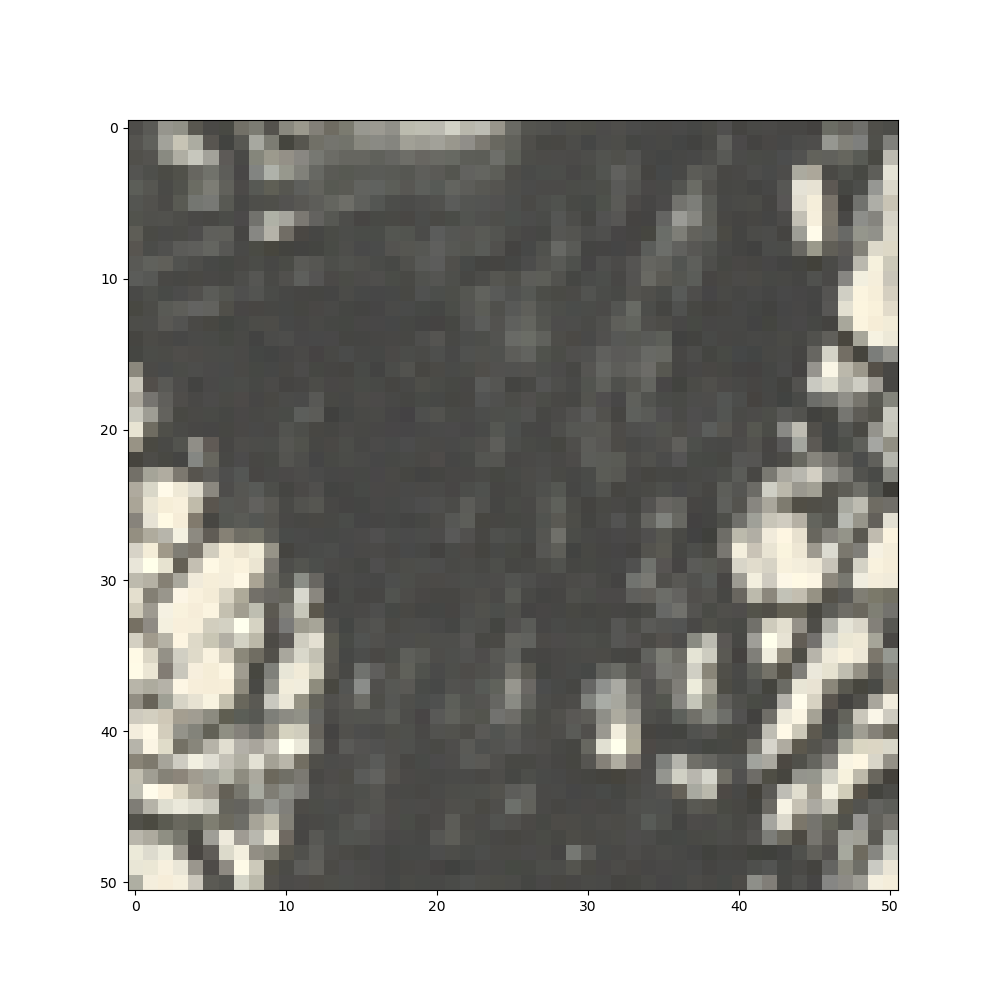

<IPython.core.display.Javascript object>


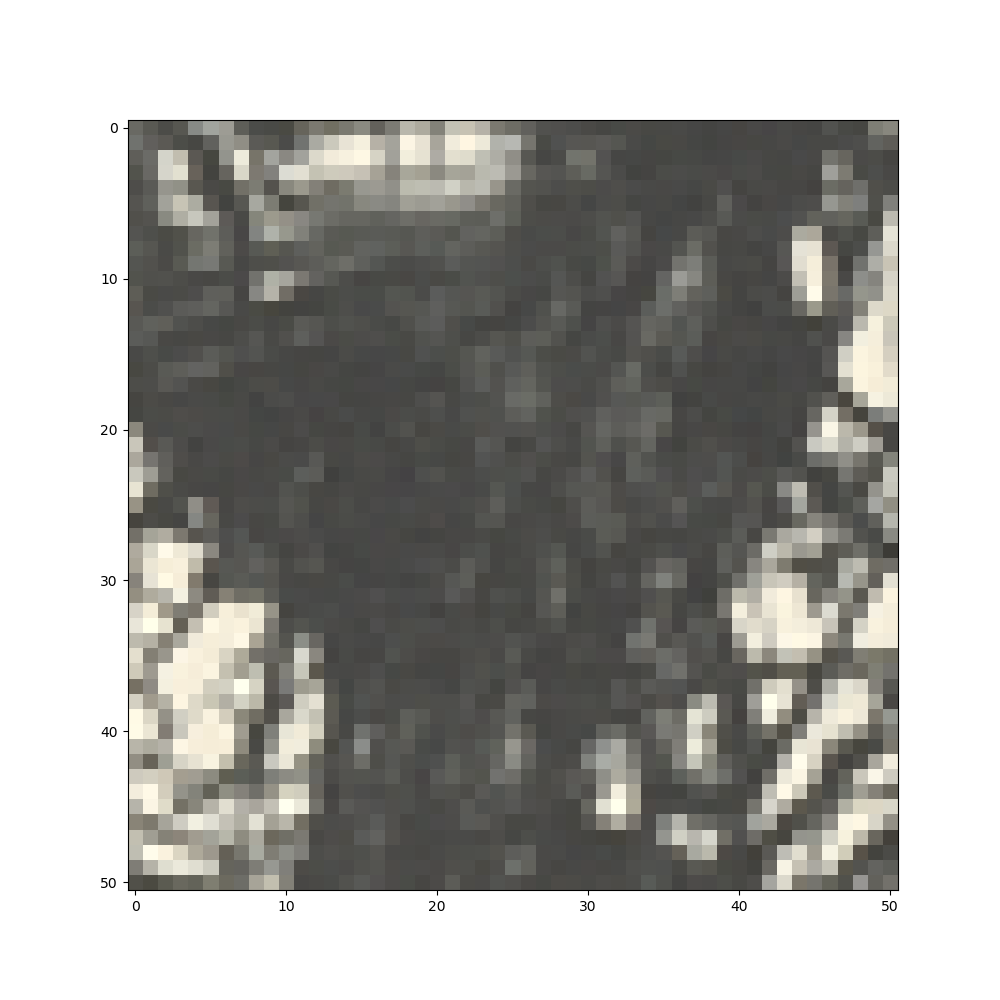

<IPython.core.display.Javascript object>


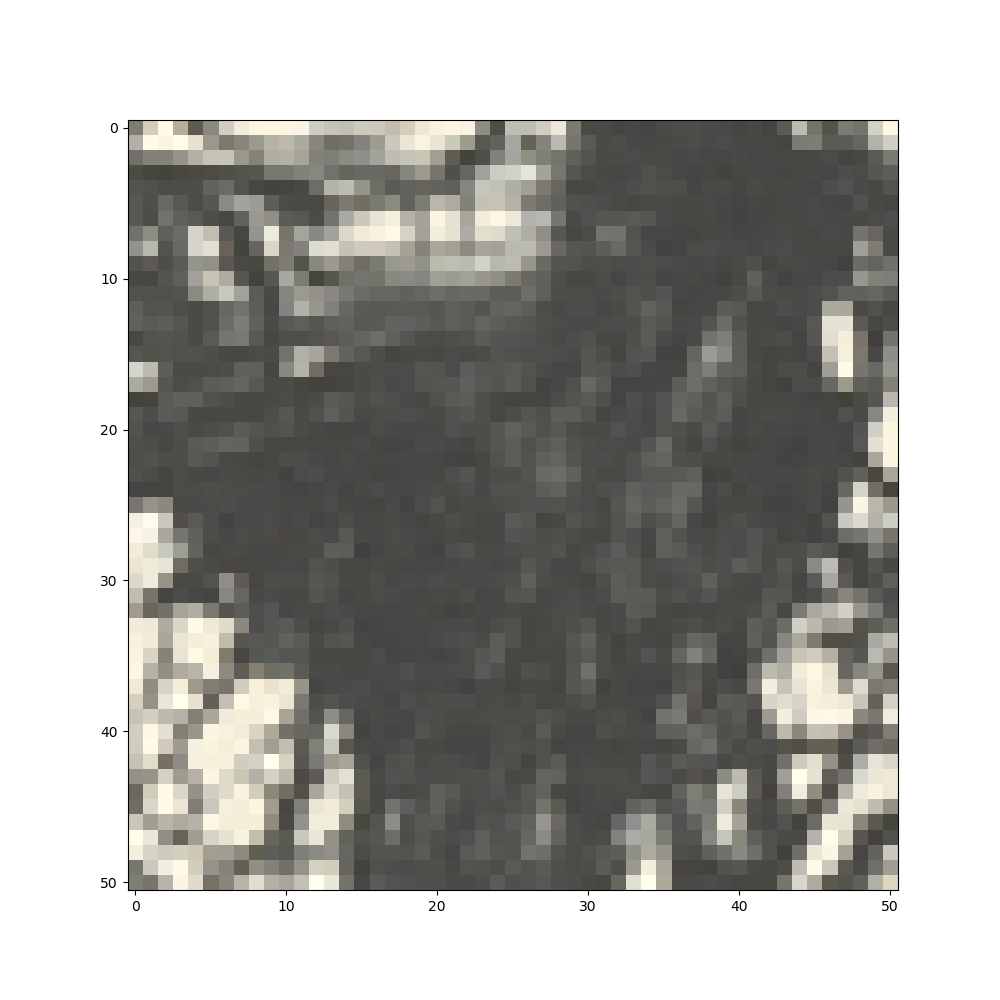

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


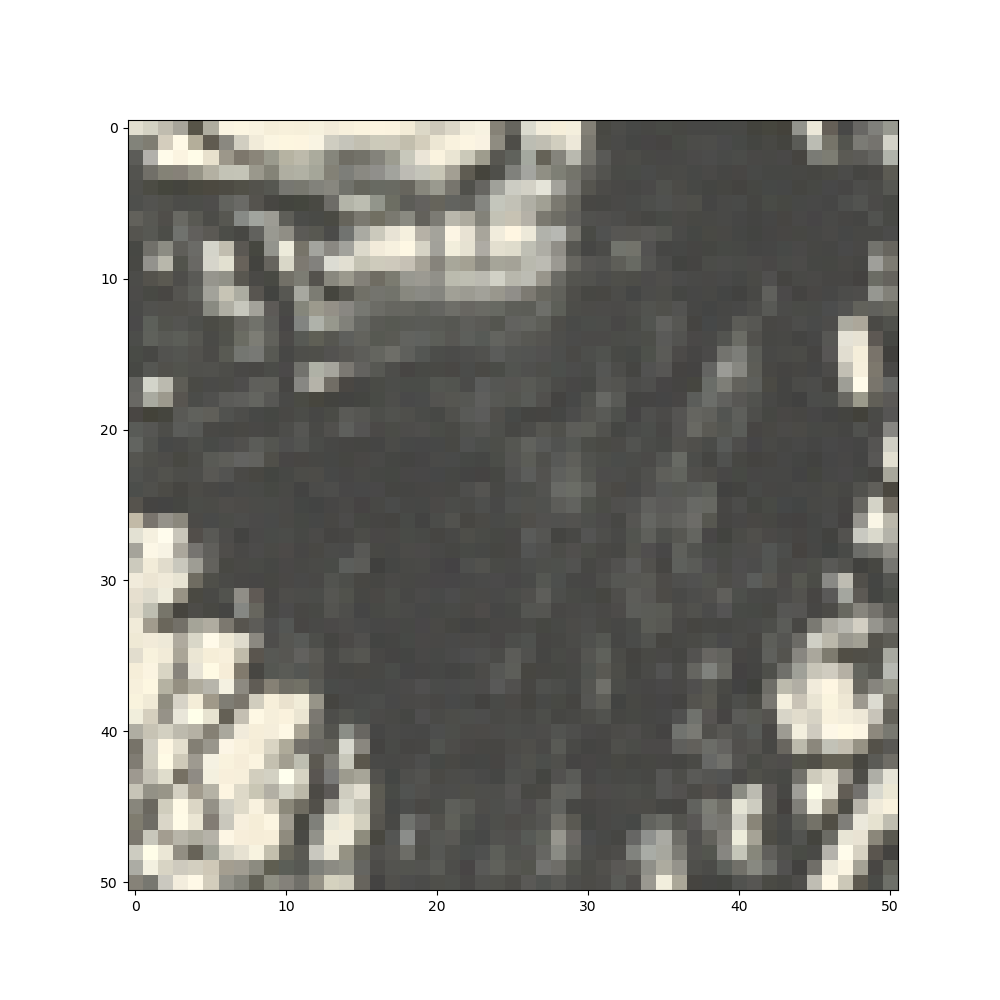

<IPython.core.display.Javascript object>


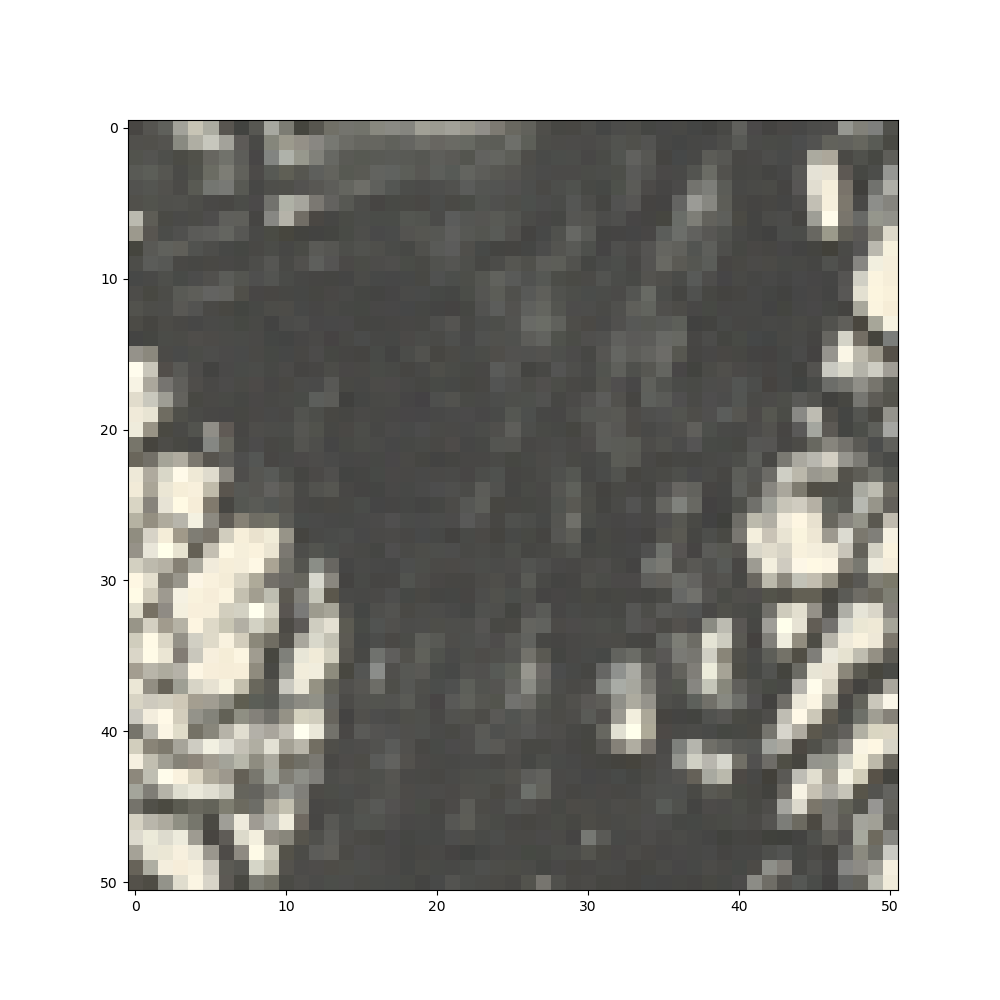

<IPython.core.display.Javascript object>


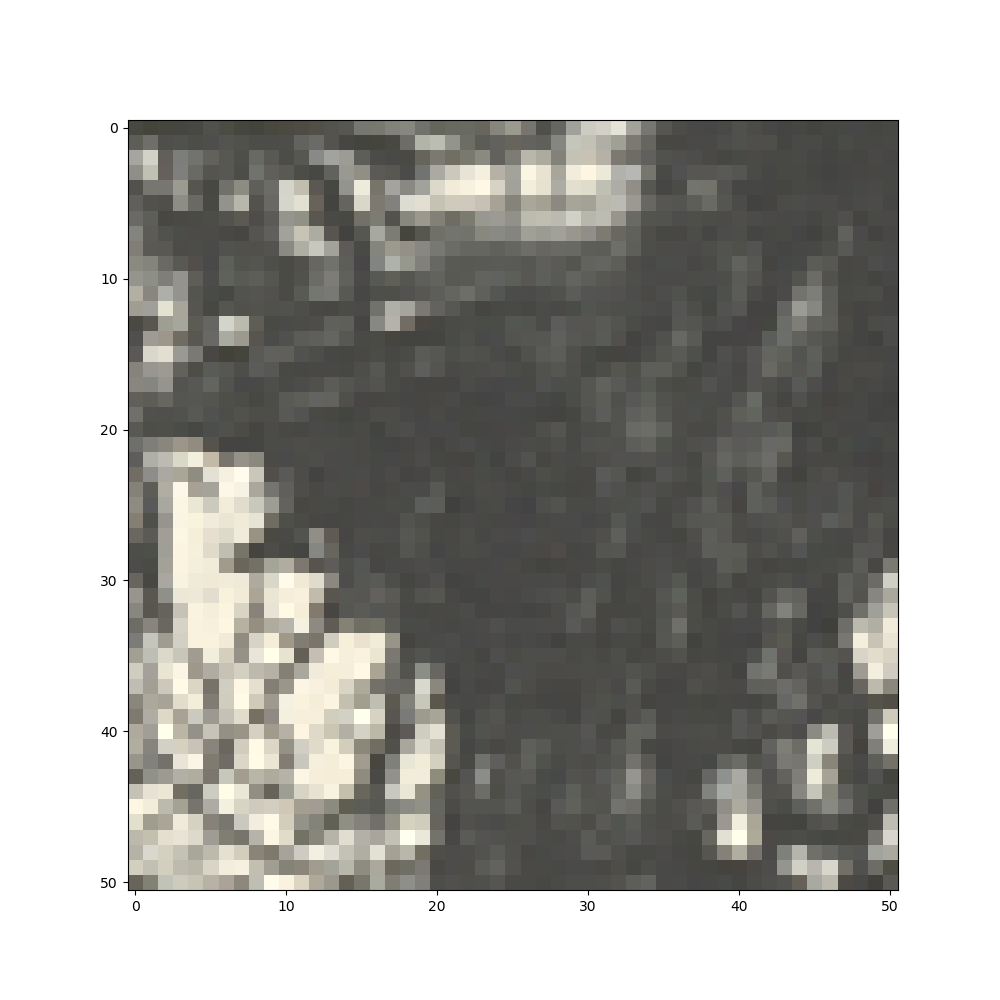

<IPython.core.display.Javascript object>


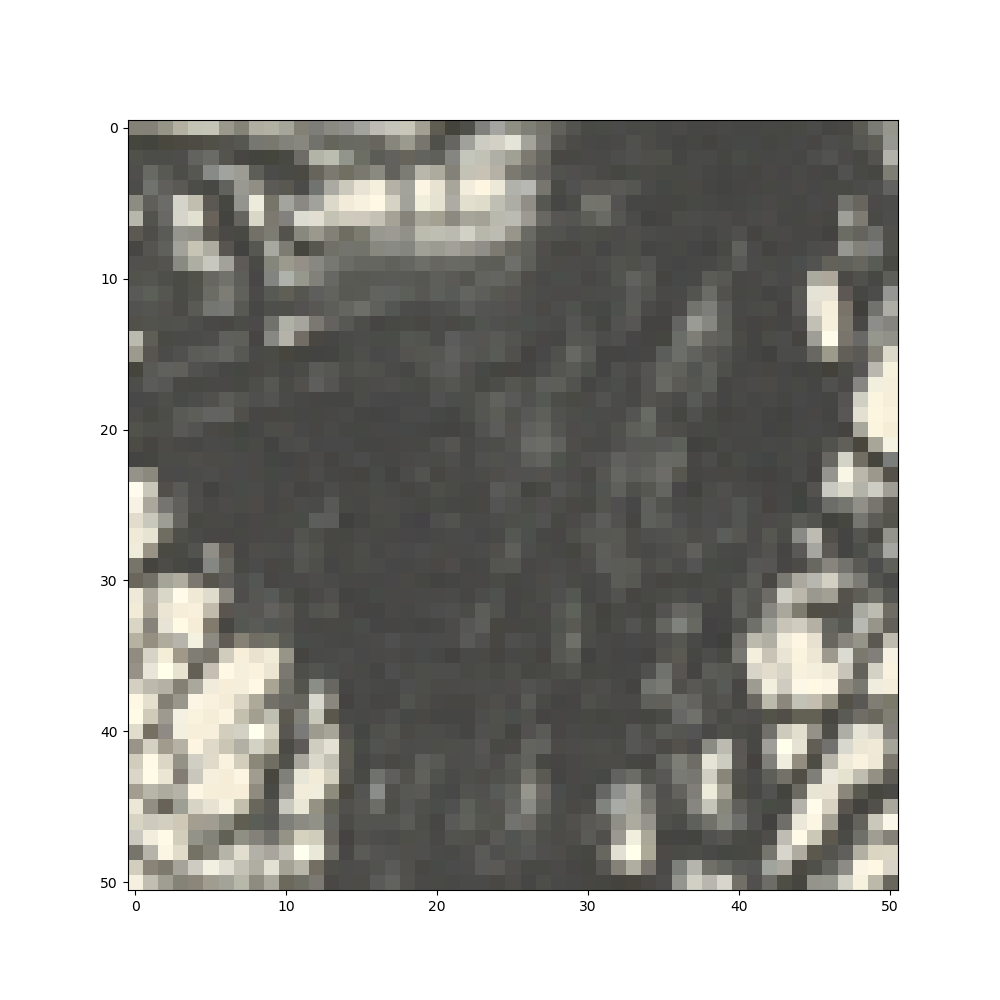

<IPython.core.display.Javascript object>


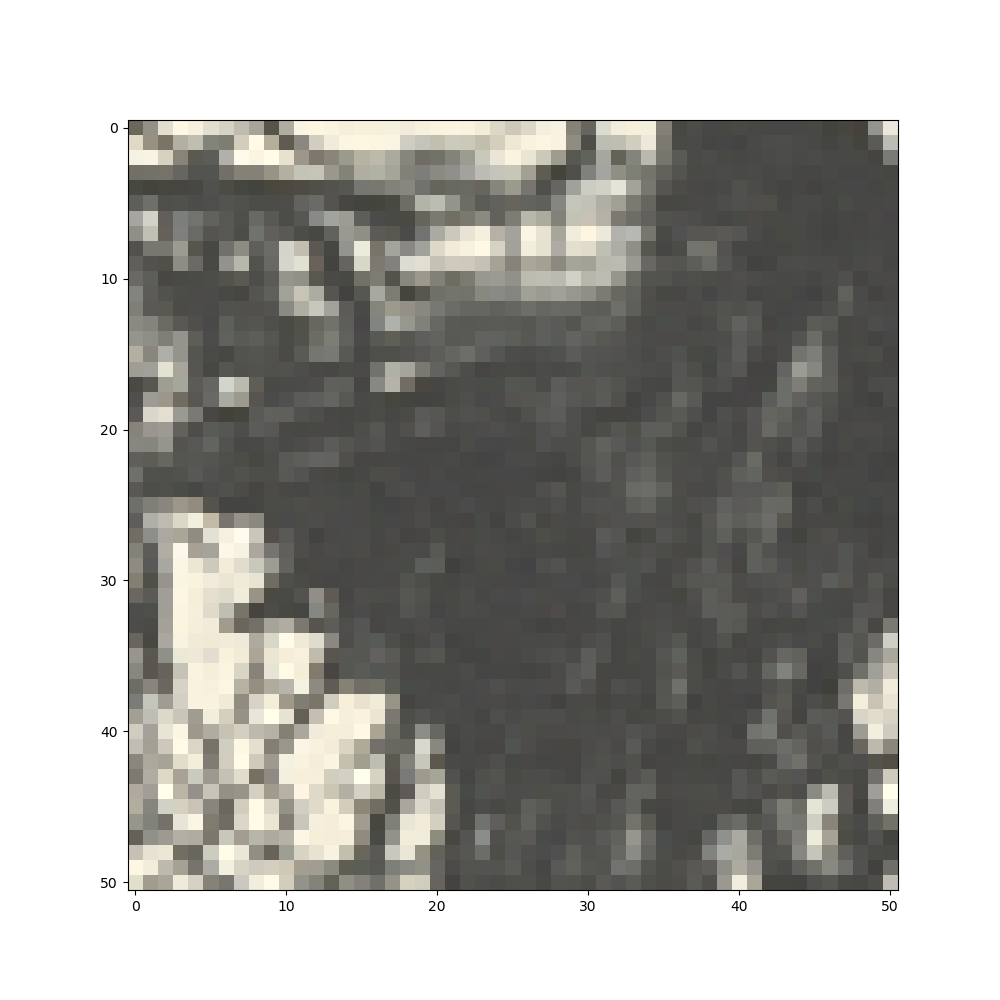

<IPython.core.display.Javascript object>


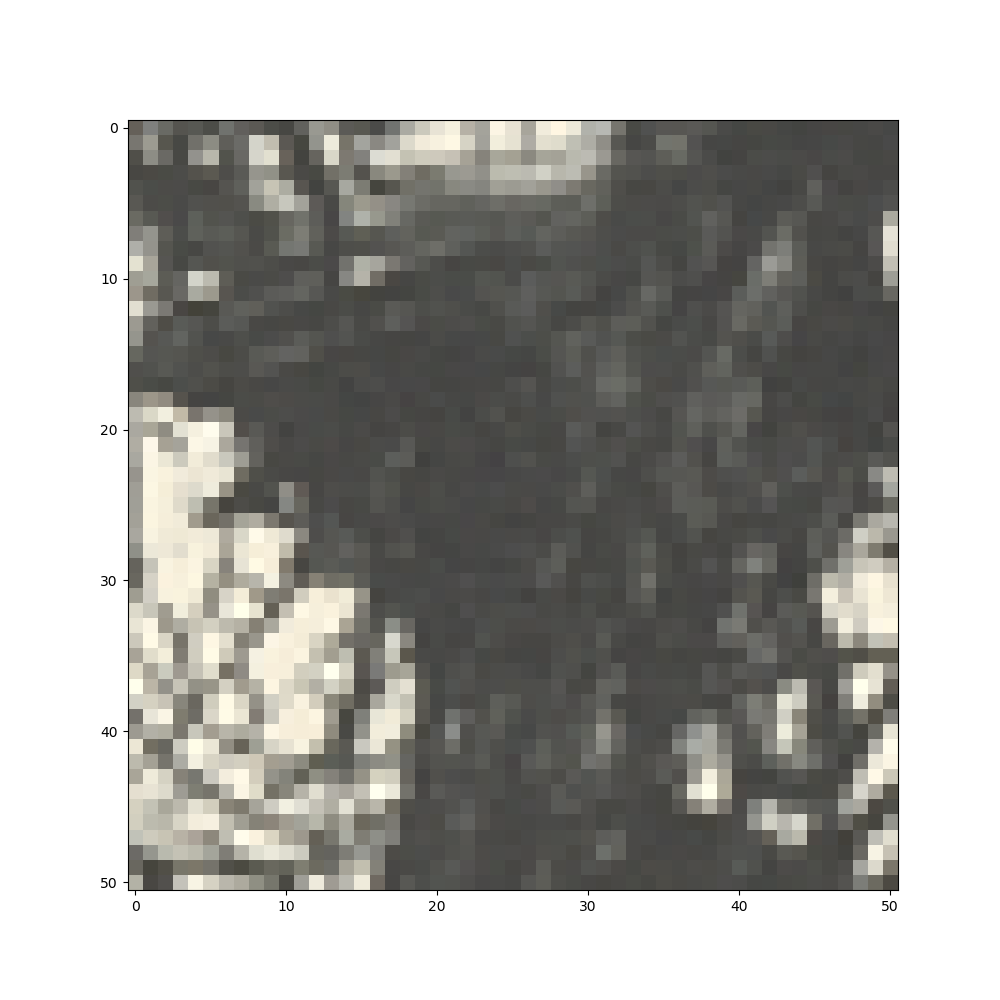

<IPython.core.display.Javascript object>


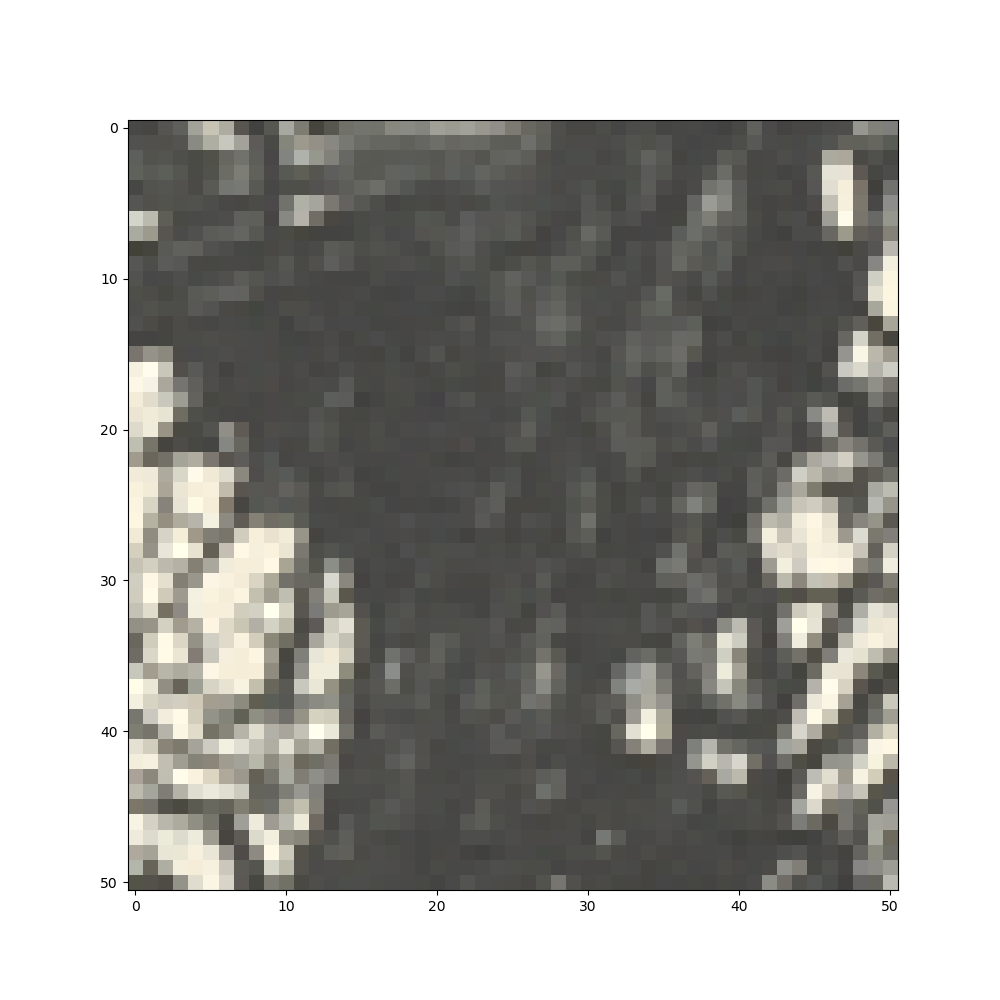

<IPython.core.display.Javascript object>


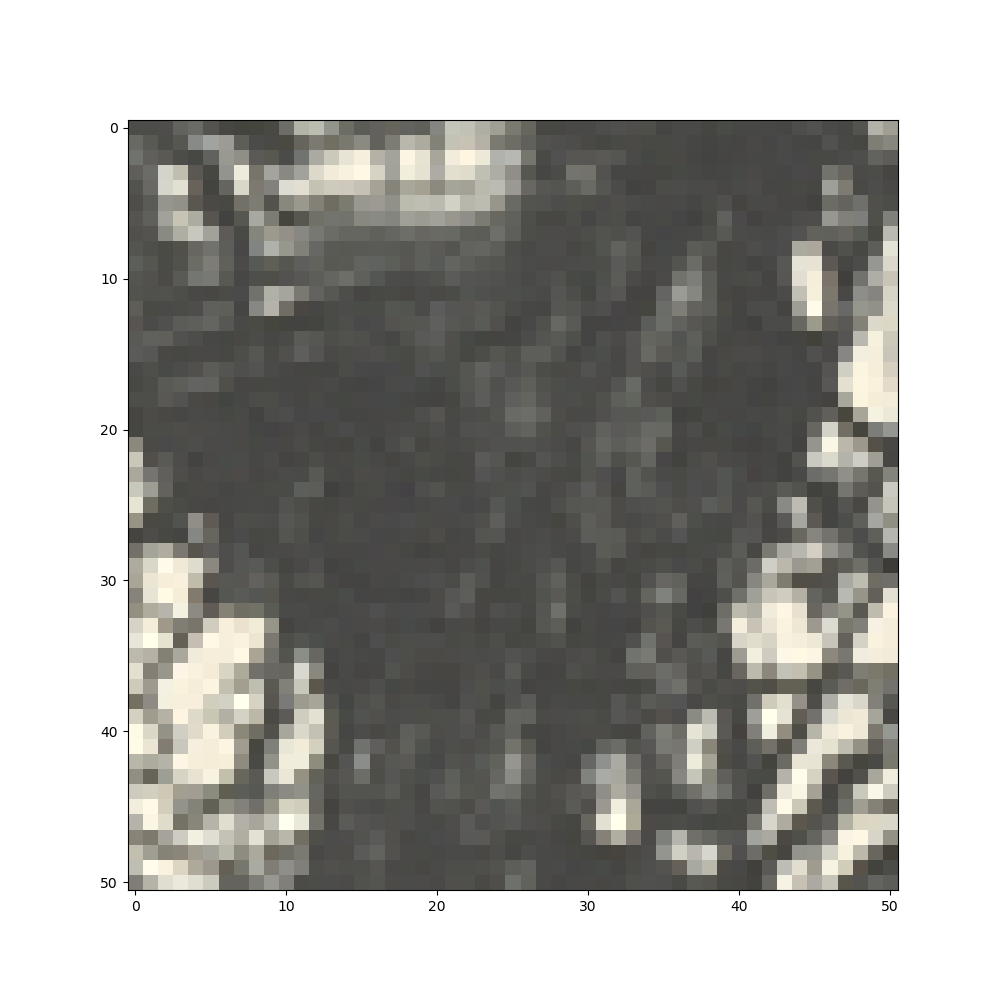

<IPython.core.display.Javascript object>


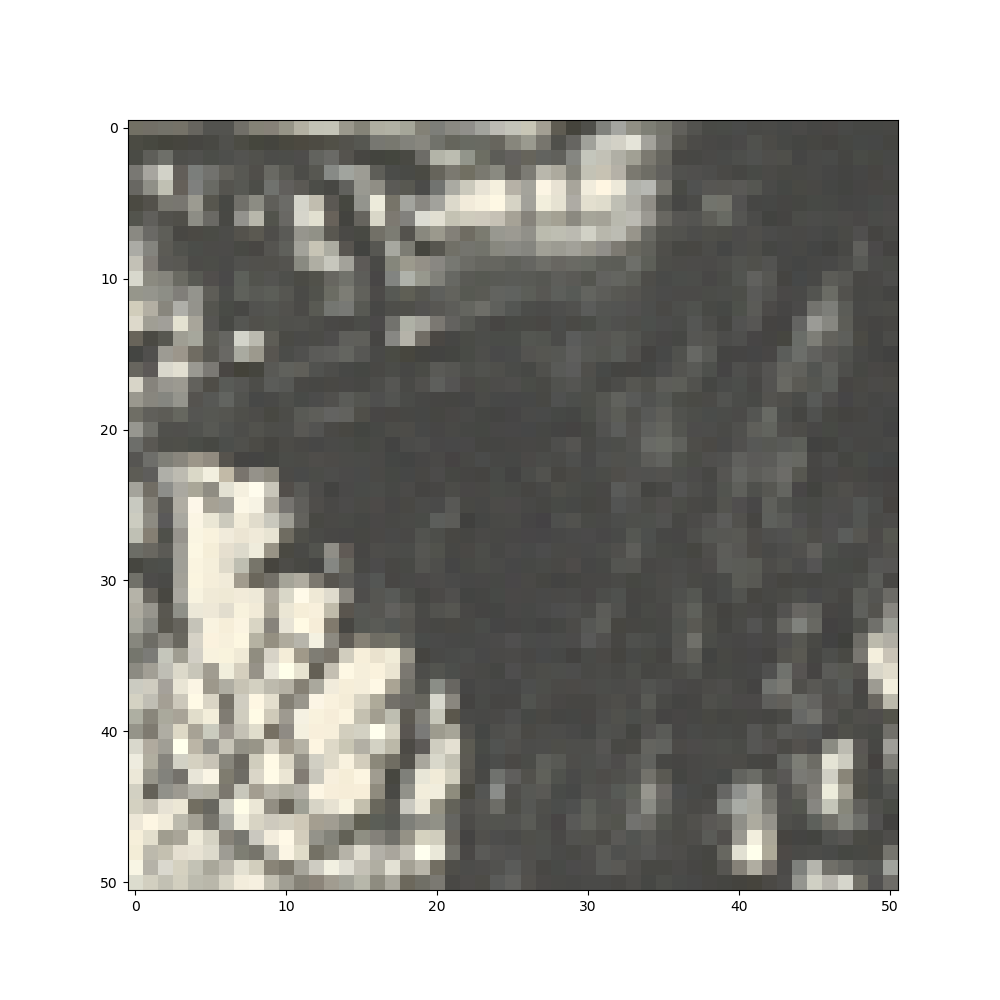

<IPython.core.display.Javascript object>


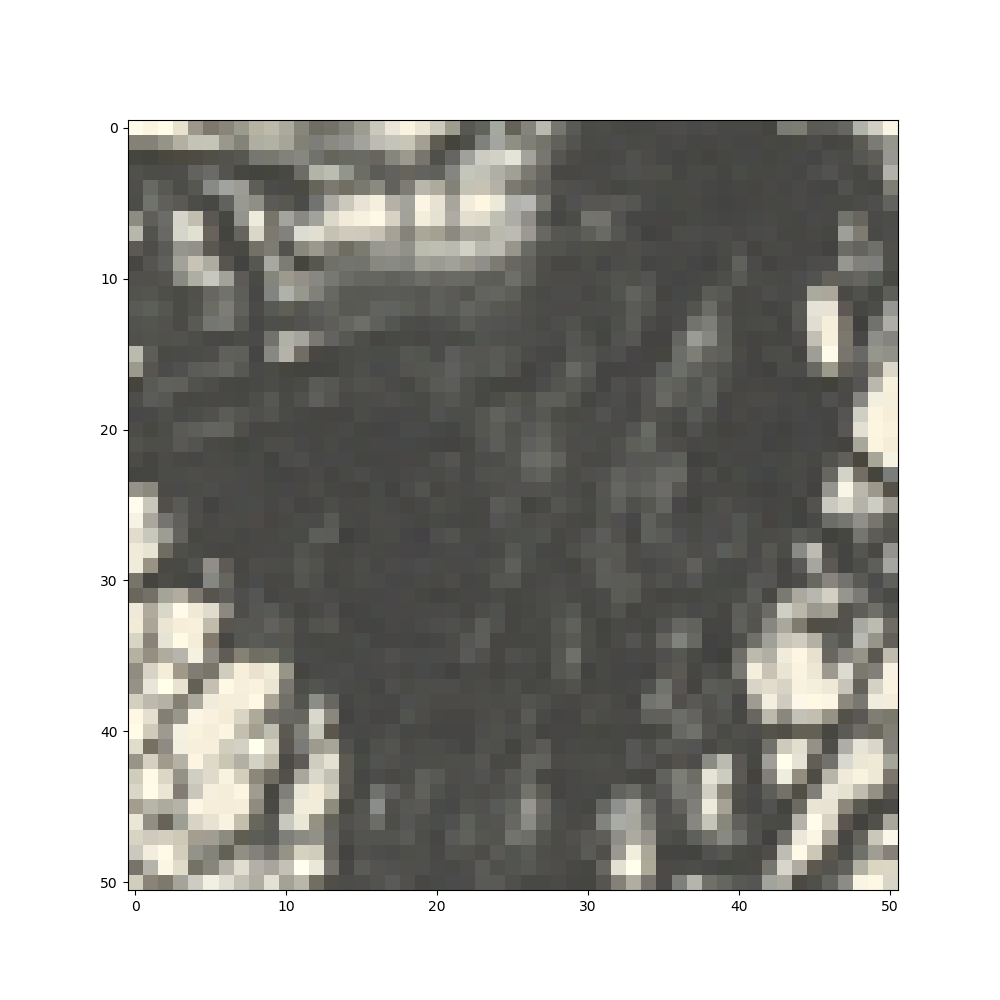

<IPython.core.display.Javascript object>


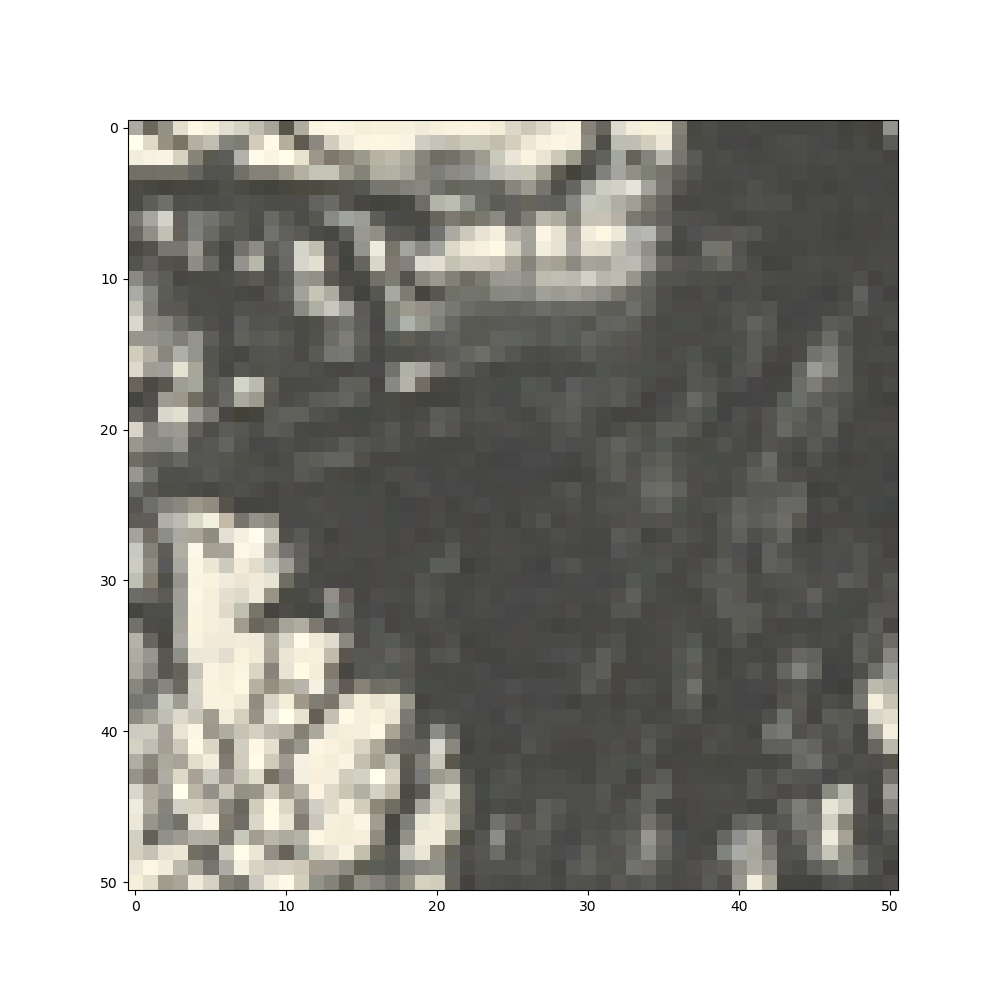

<IPython.core.display.Javascript object>


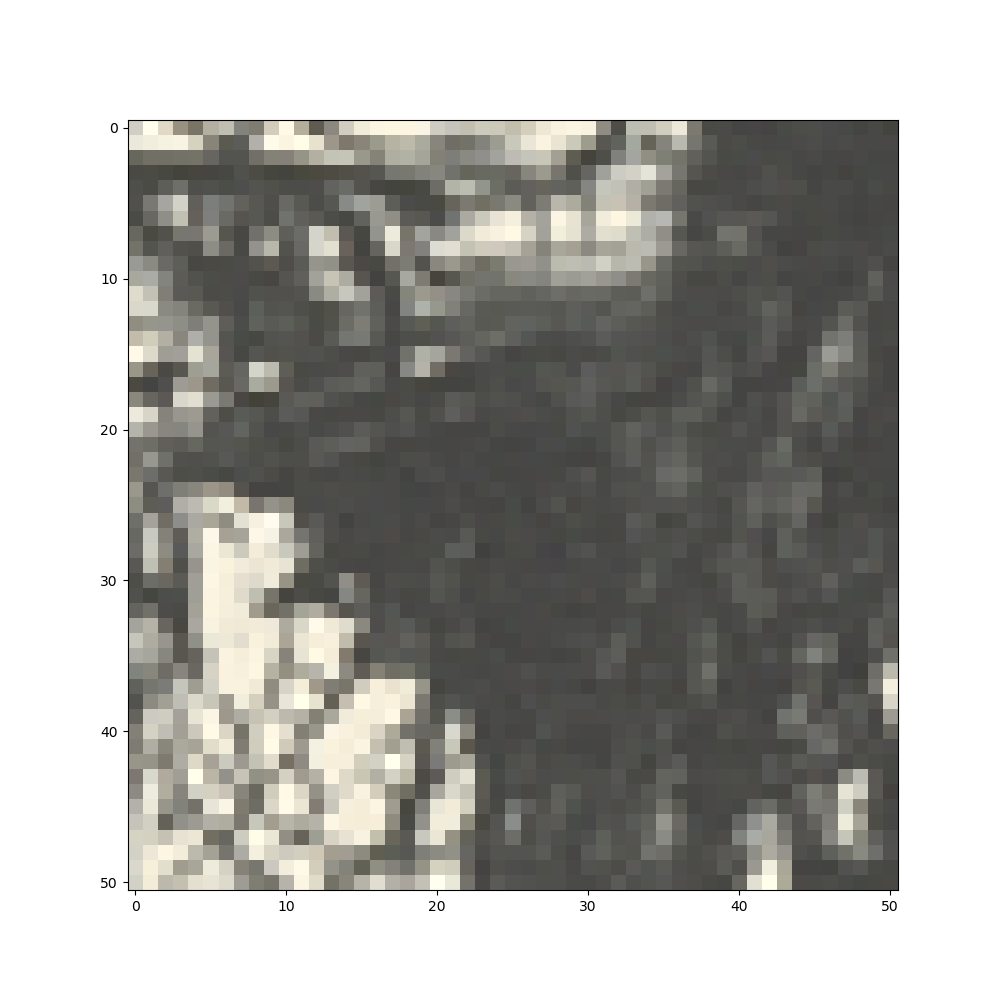

<IPython.core.display.Javascript object>


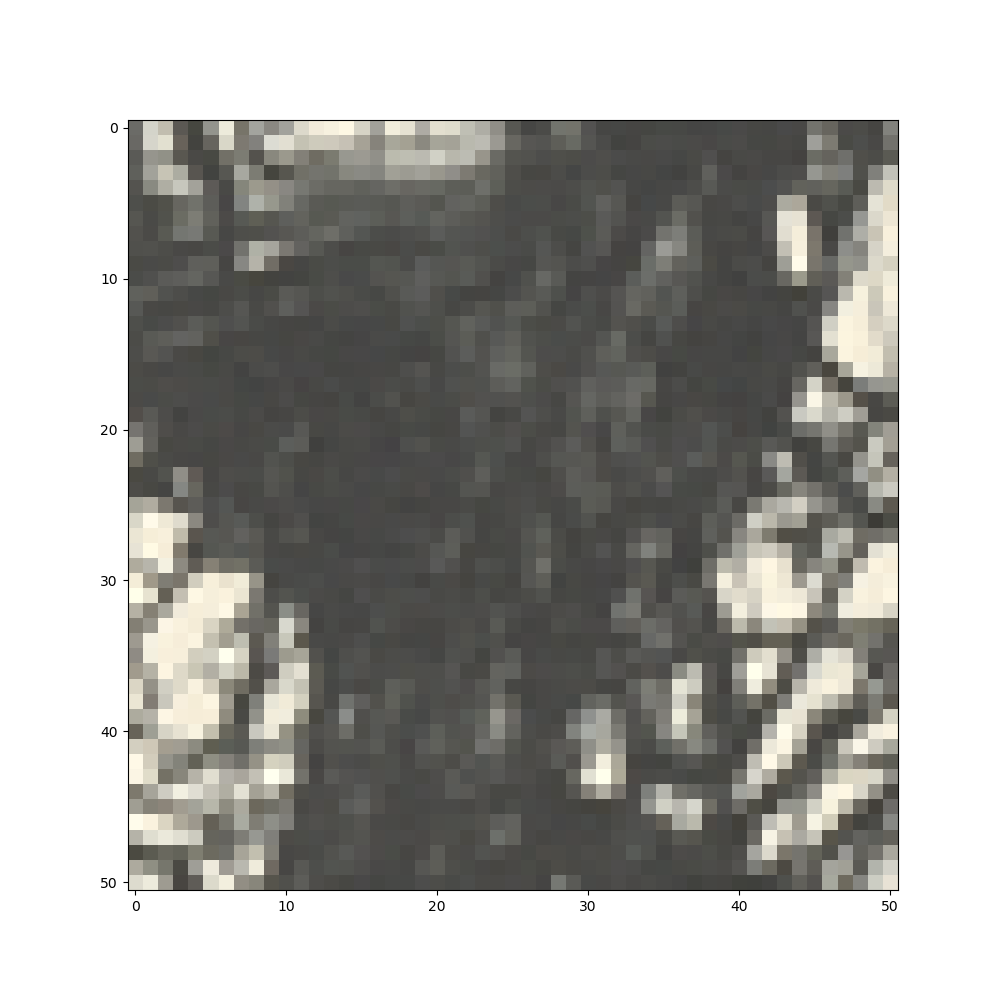

<IPython.core.display.Javascript object>


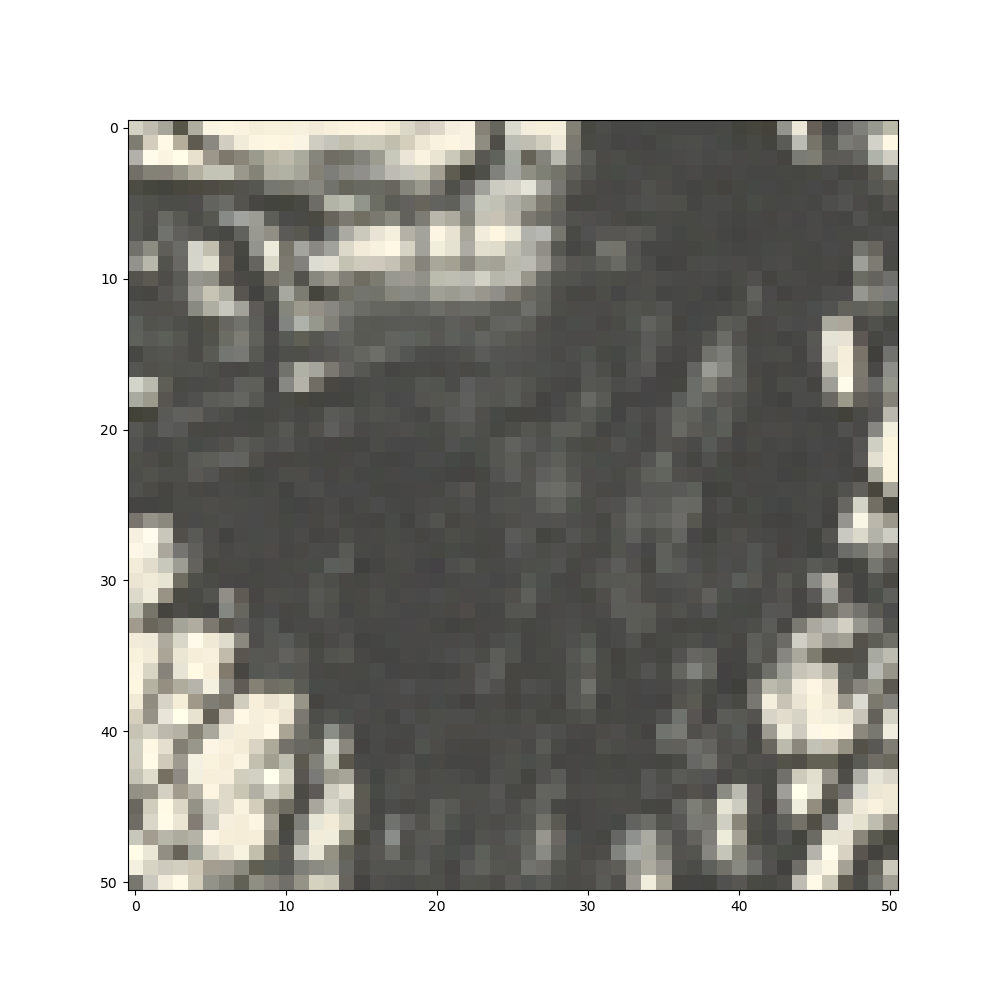

<IPython.core.display.Javascript object>


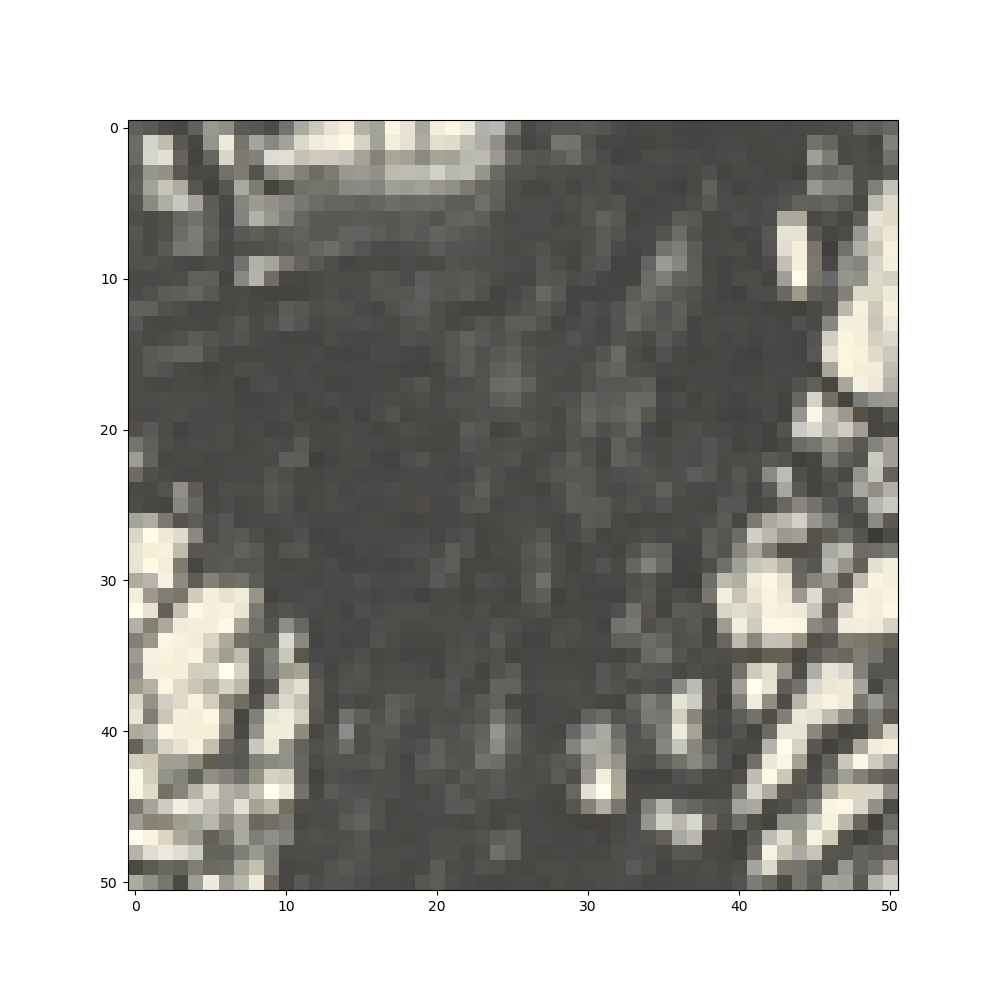

<IPython.core.display.Javascript object>


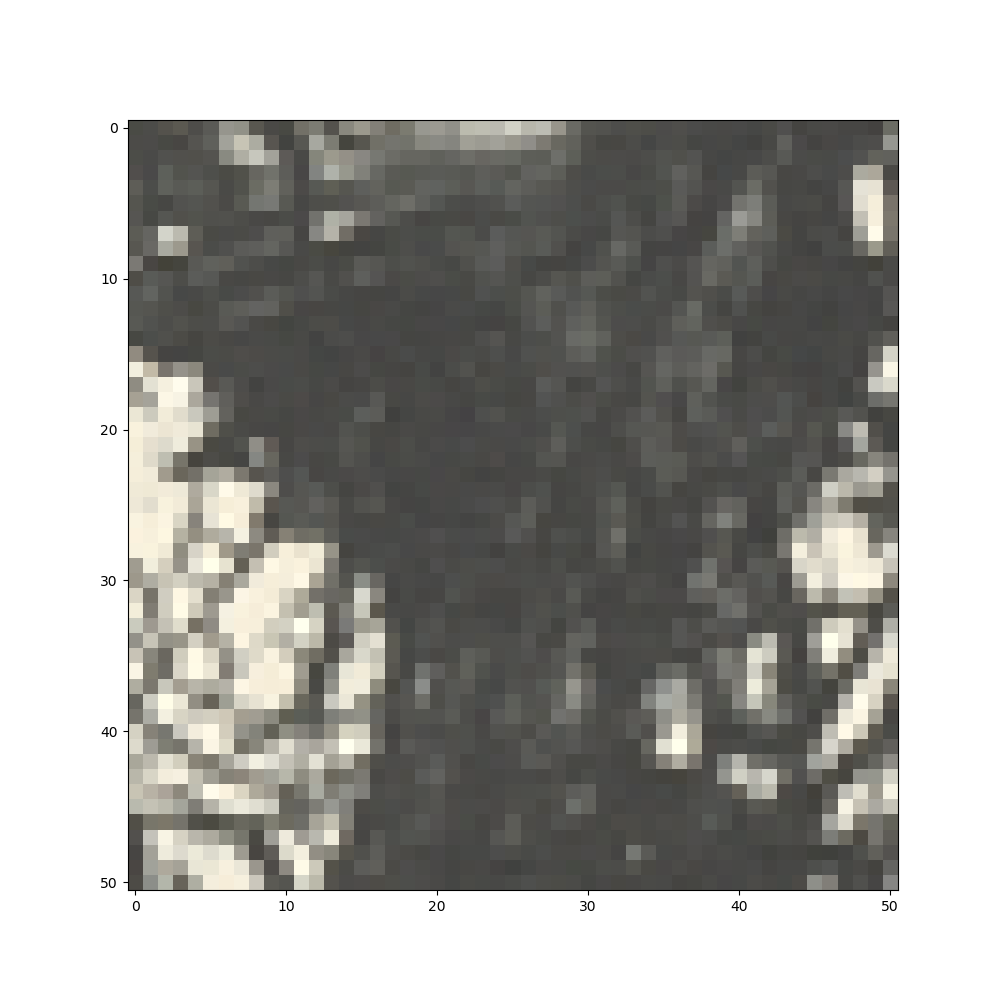

<IPython.core.display.Javascript object>


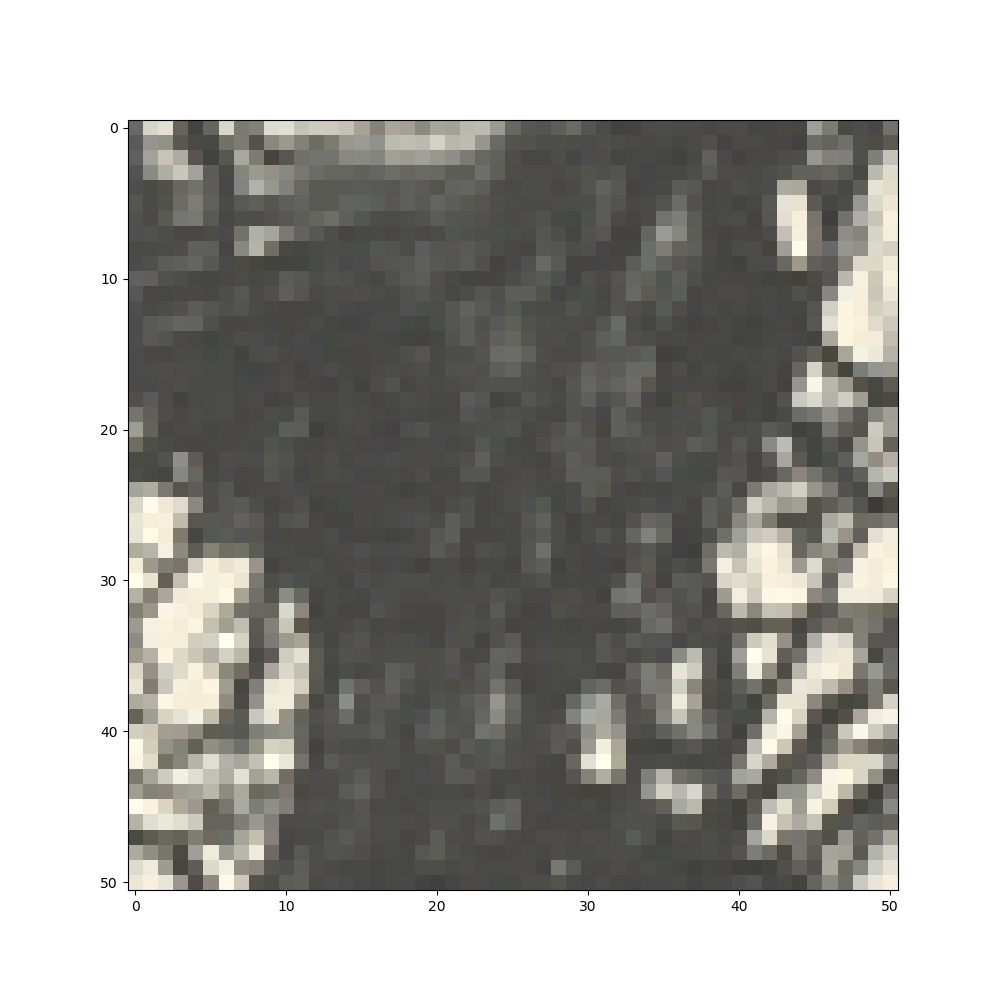

<IPython.core.display.Javascript object>


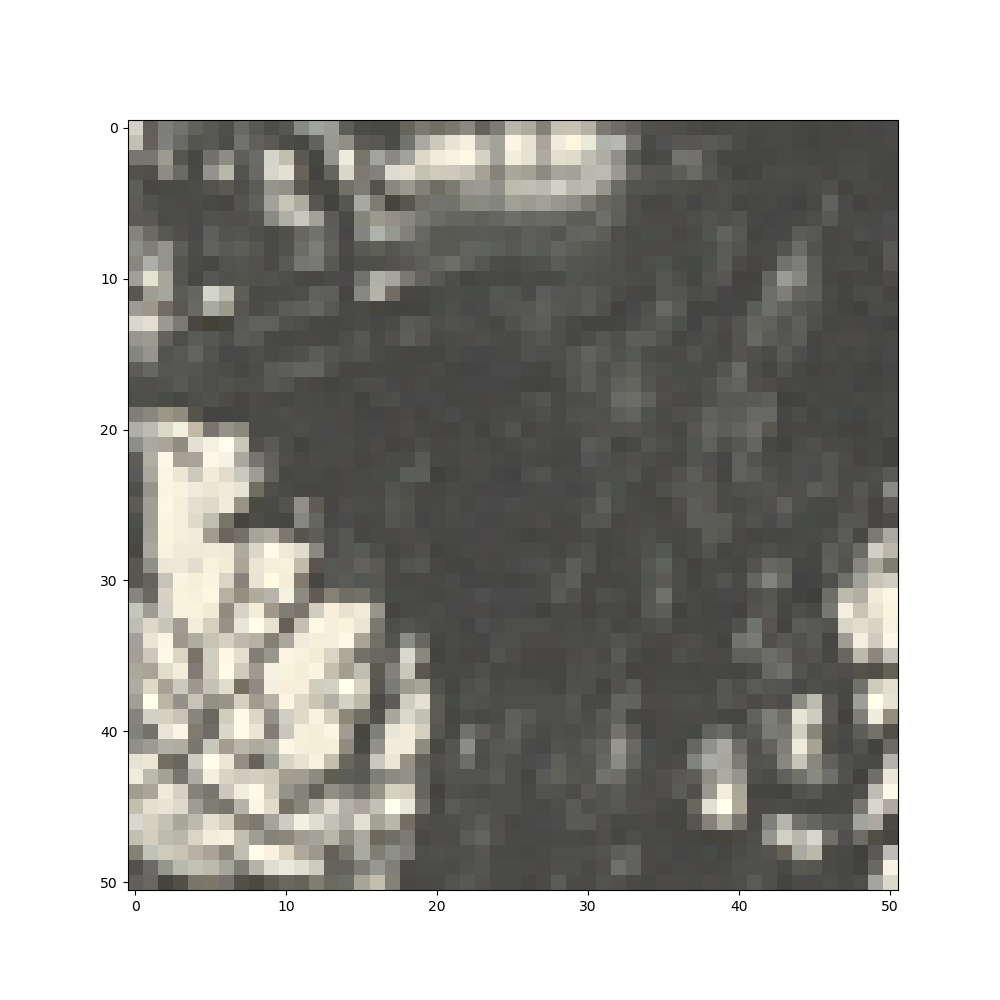

<IPython.core.display.Javascript object>


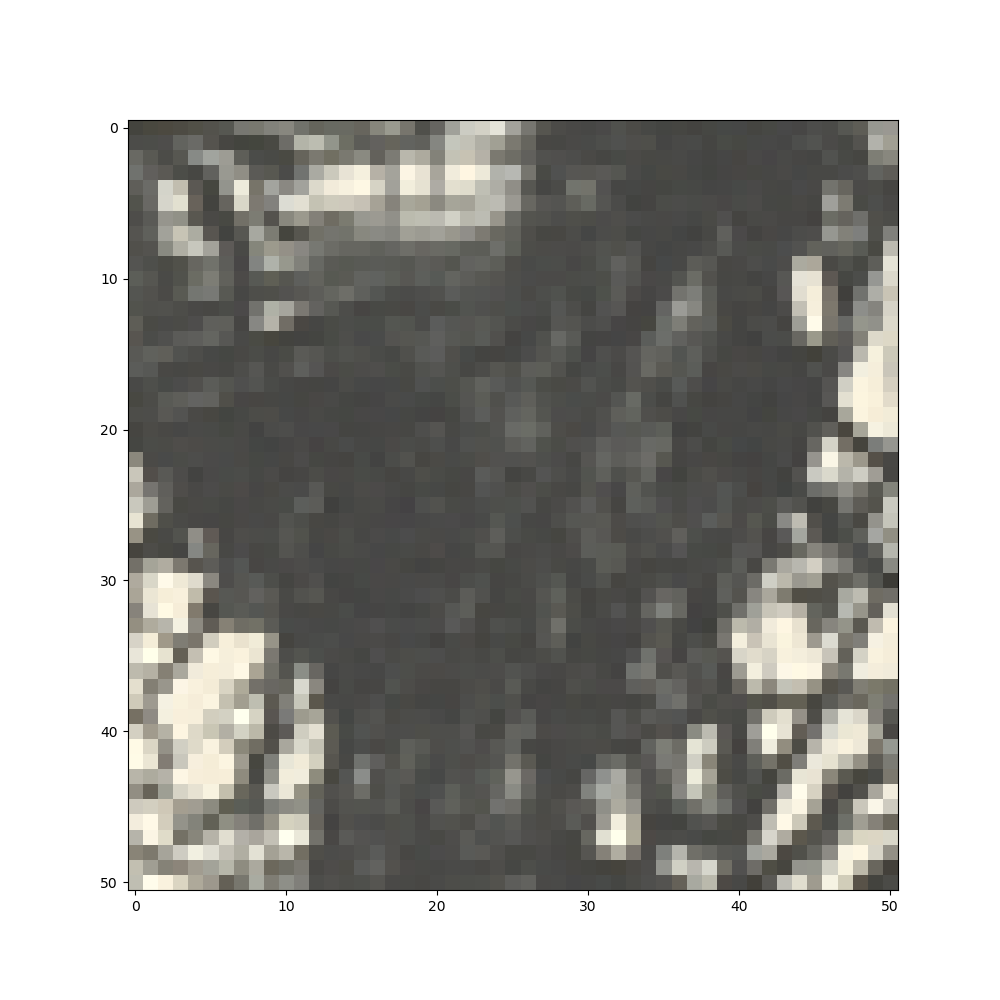

<IPython.core.display.Javascript object>


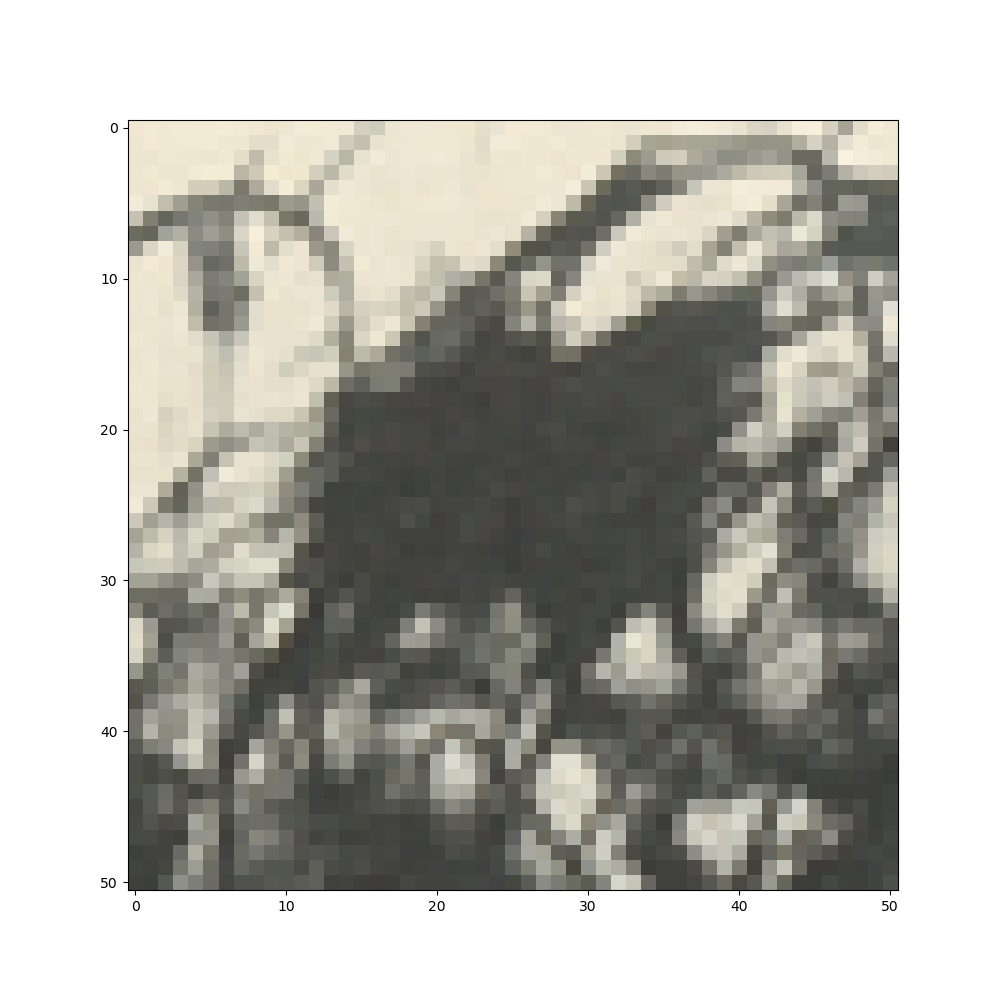

<IPython.core.display.Javascript object>


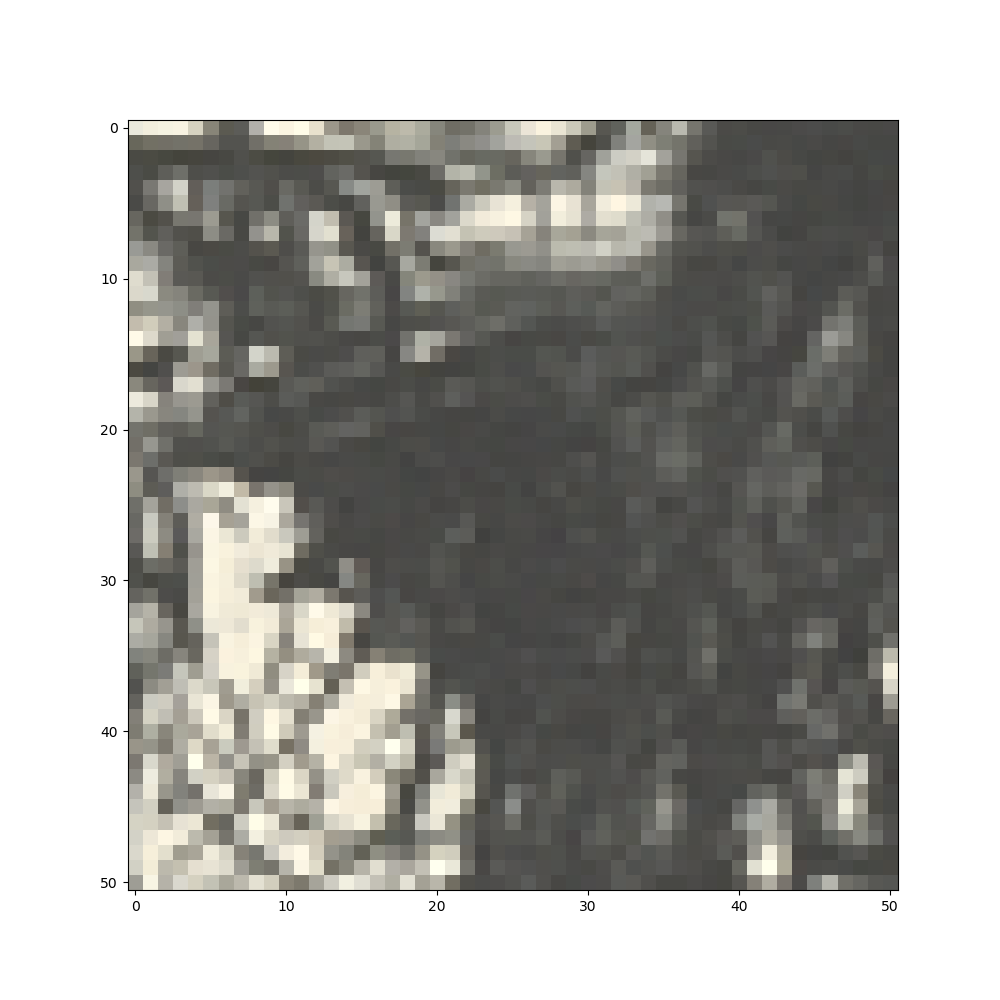

<IPython.core.display.Javascript object>


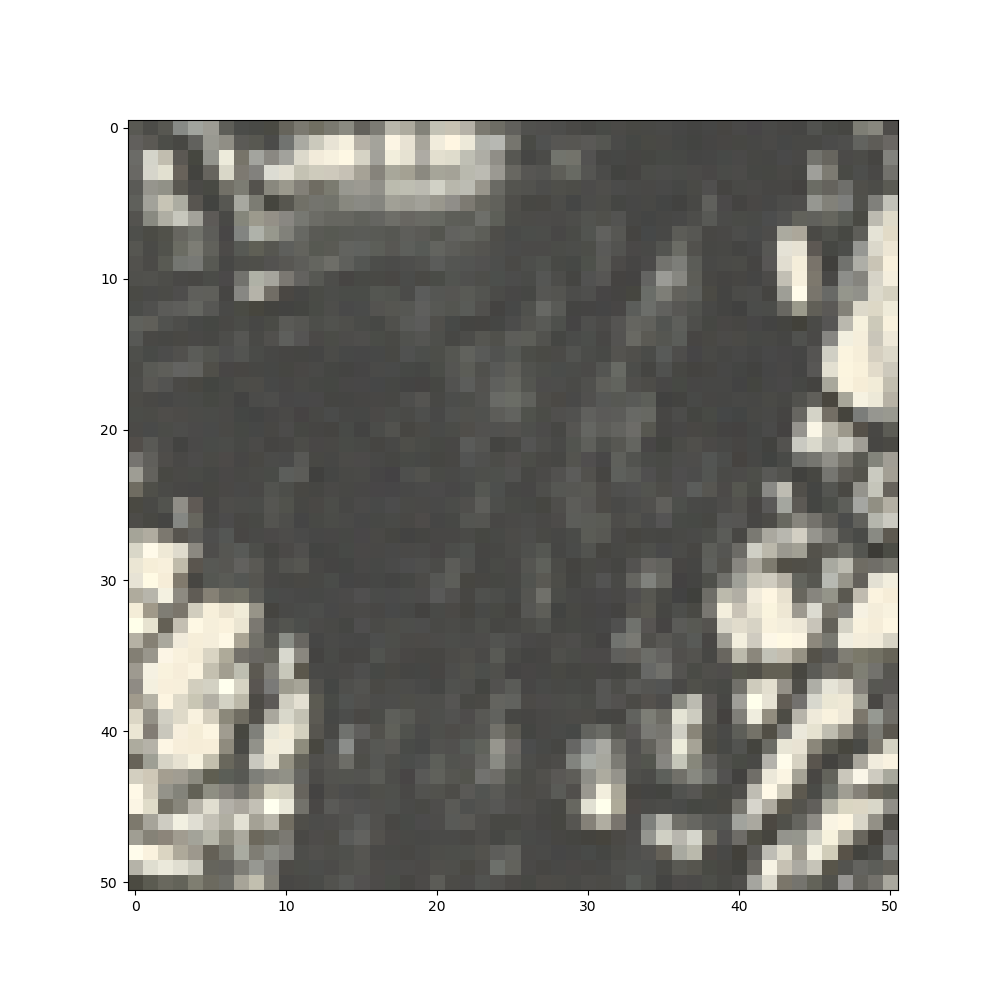

<IPython.core.display.Javascript object>


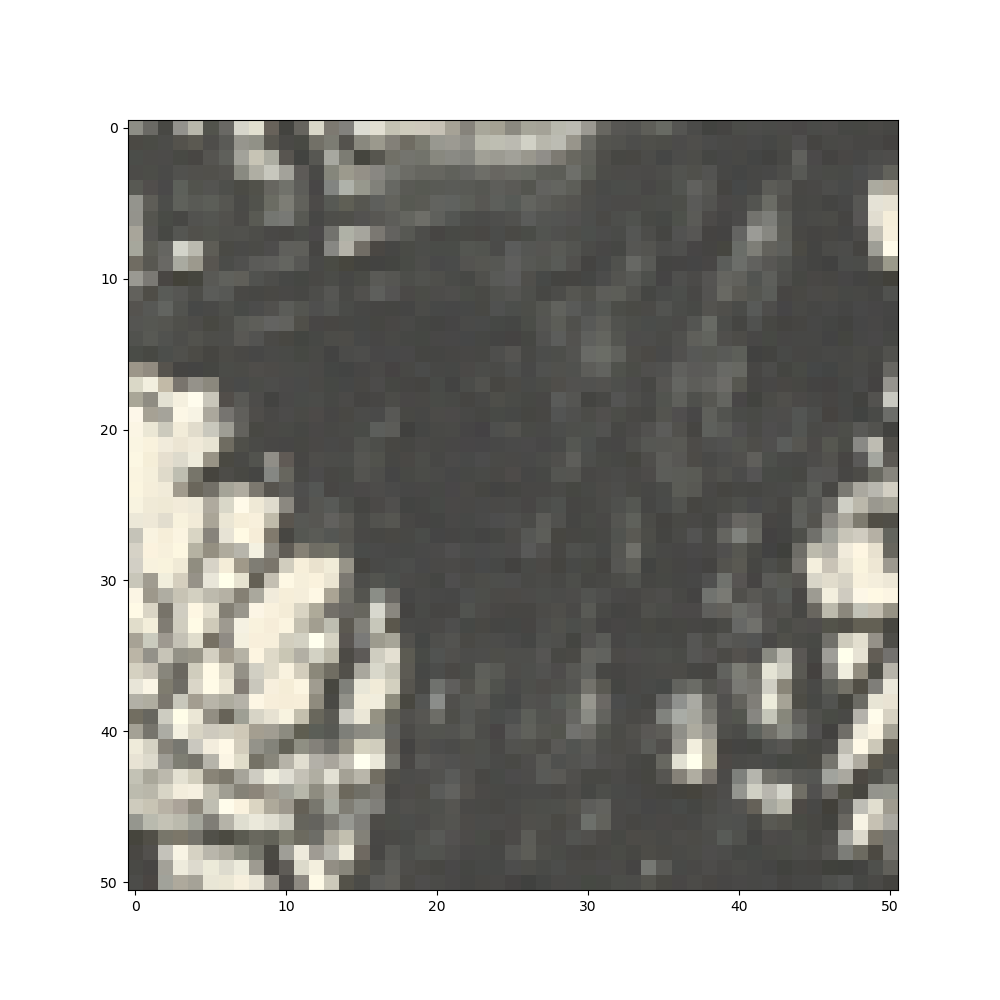

<IPython.core.display.Javascript object>


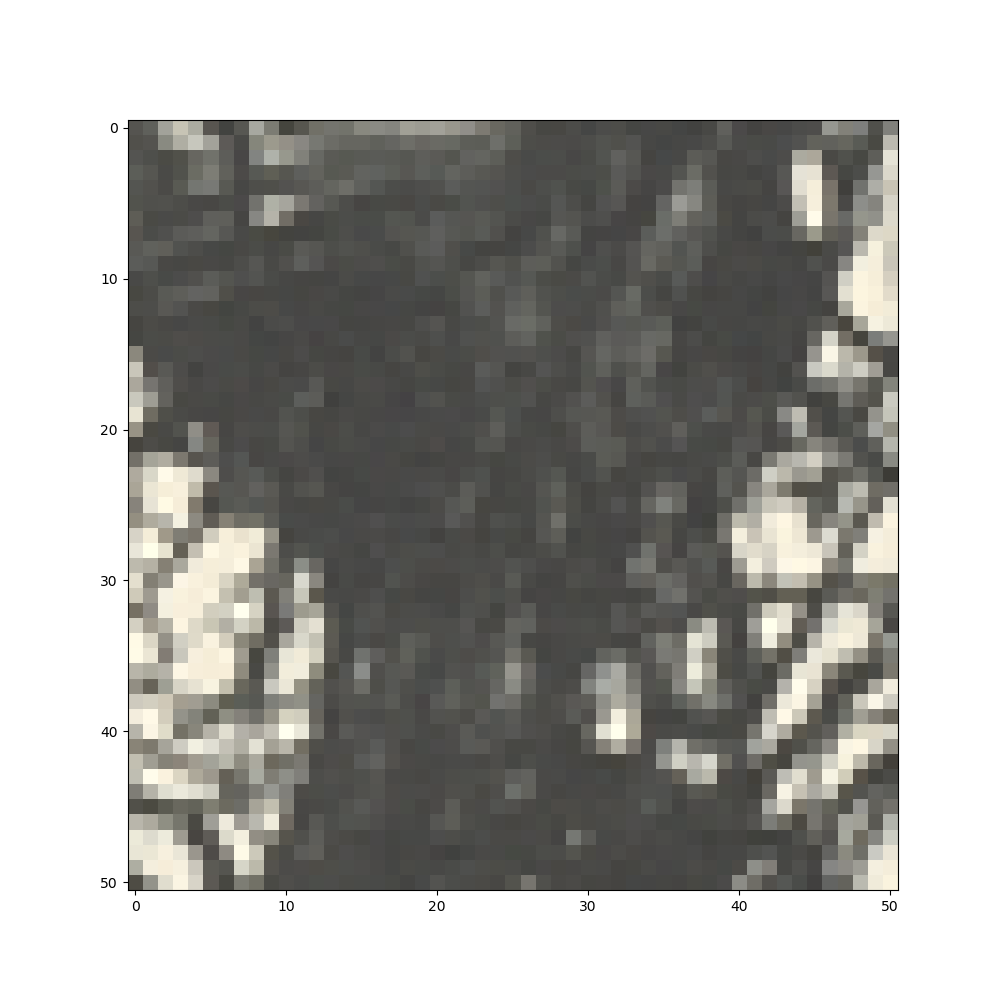

<IPython.core.display.Javascript object>


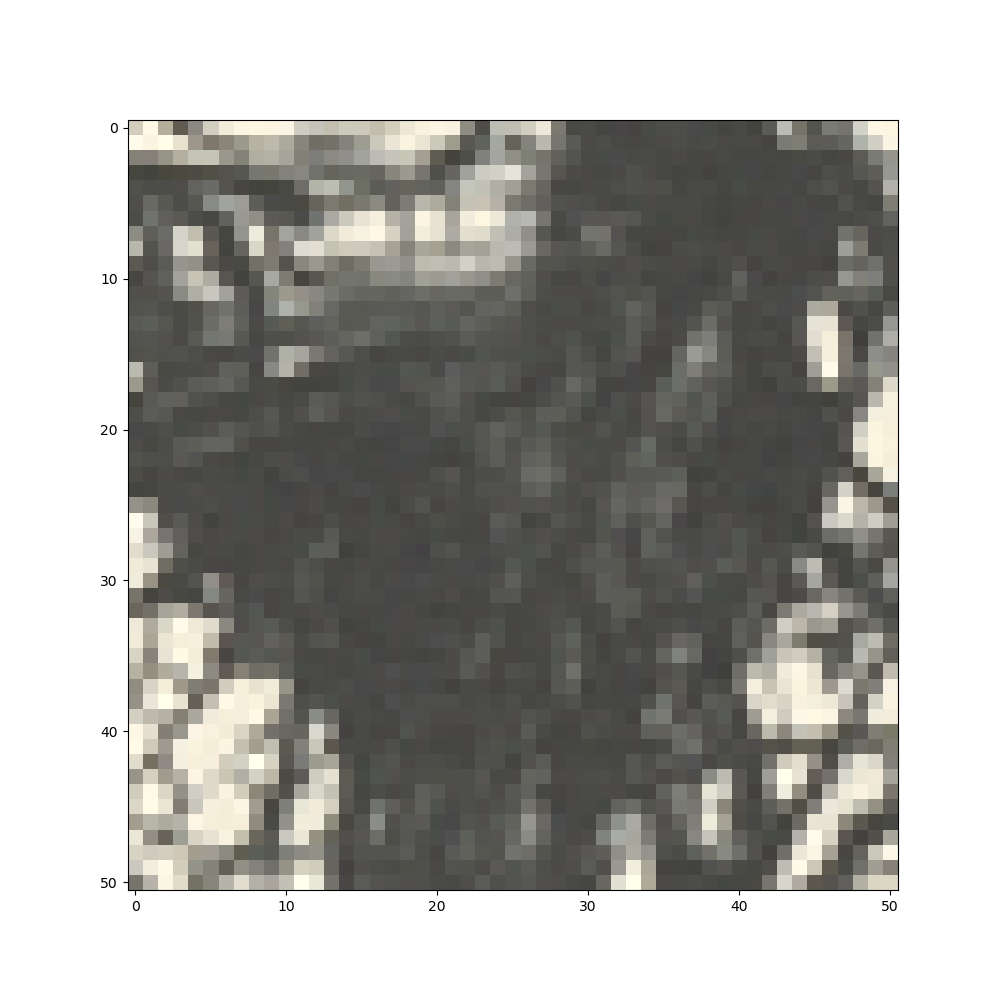

<IPython.core.display.Javascript object>


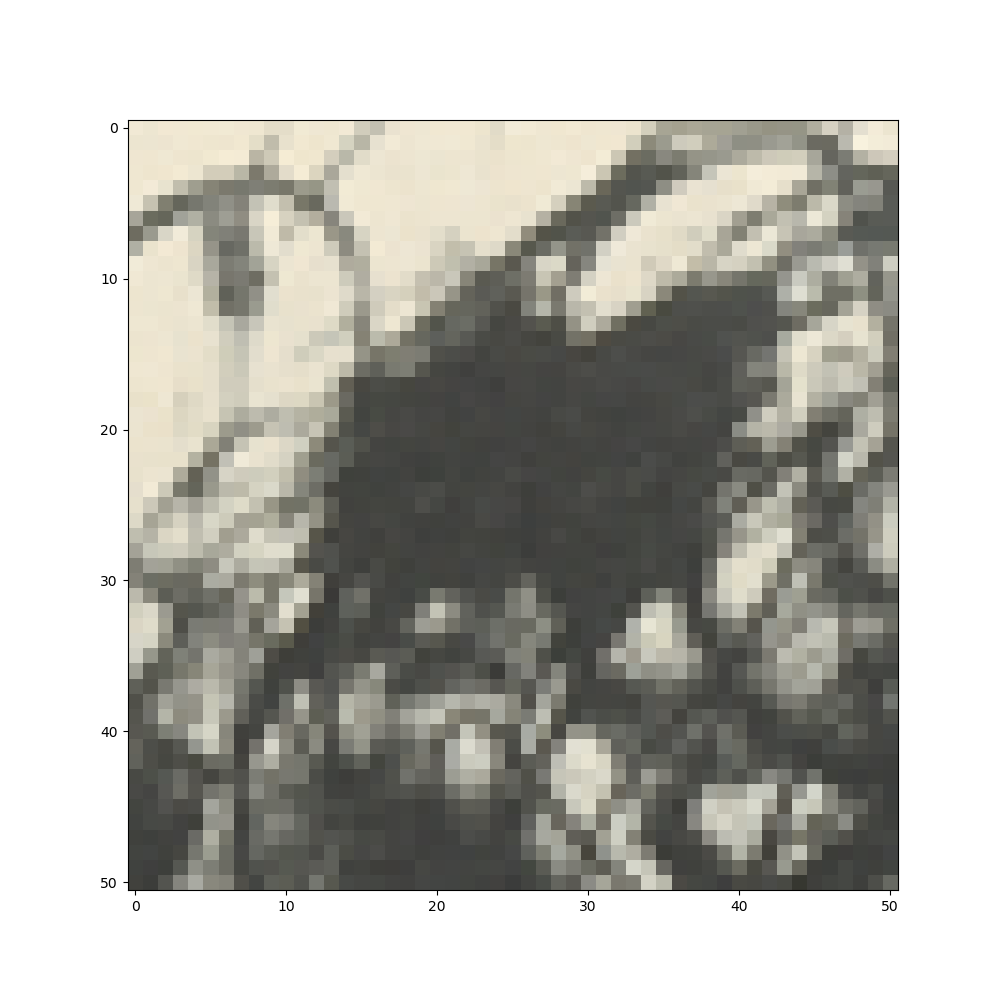

<IPython.core.display.Javascript object>


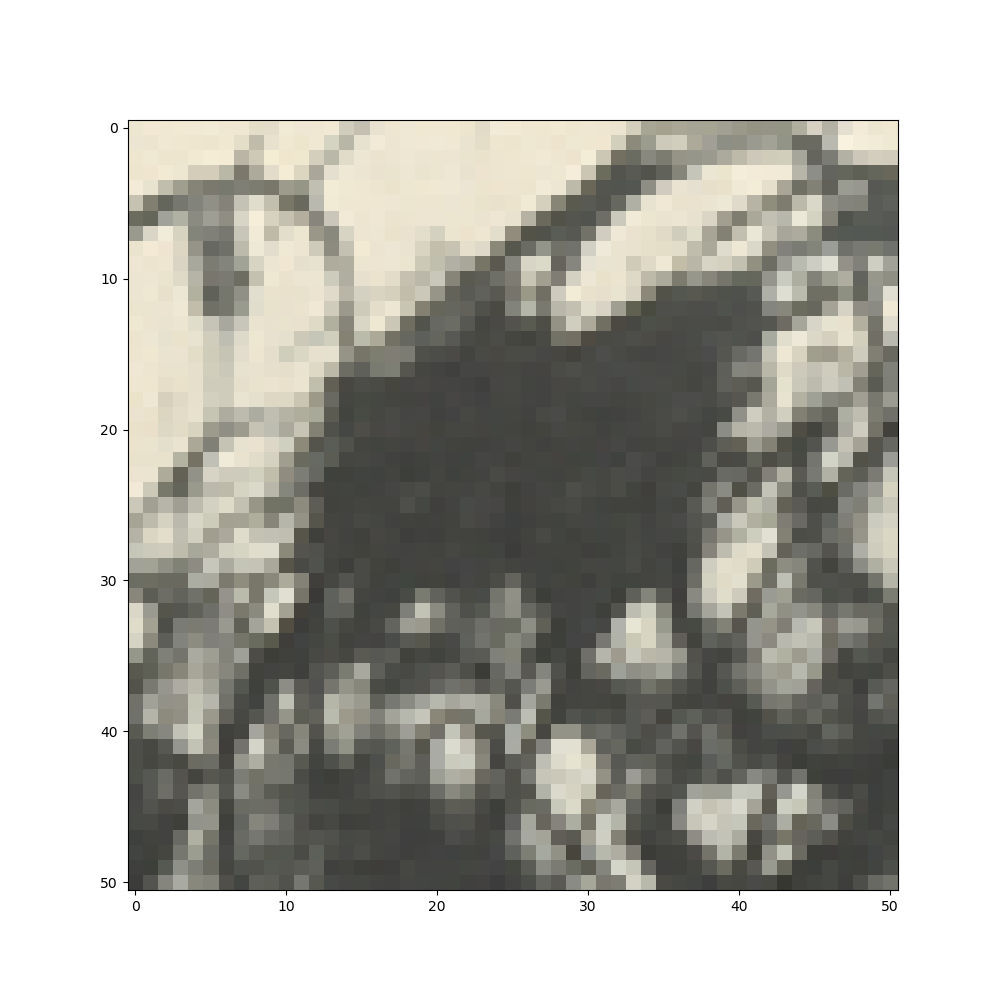

<IPython.core.display.Javascript object>


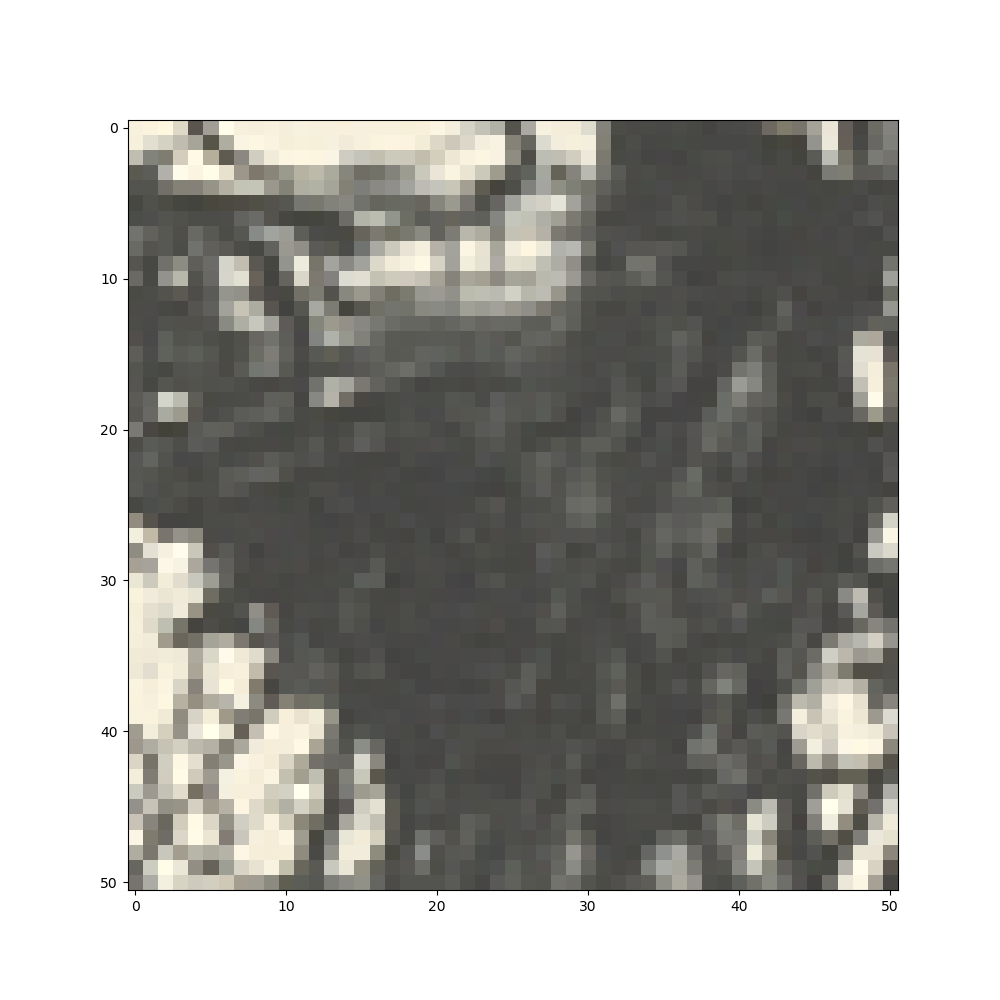

<IPython.core.display.Javascript object>


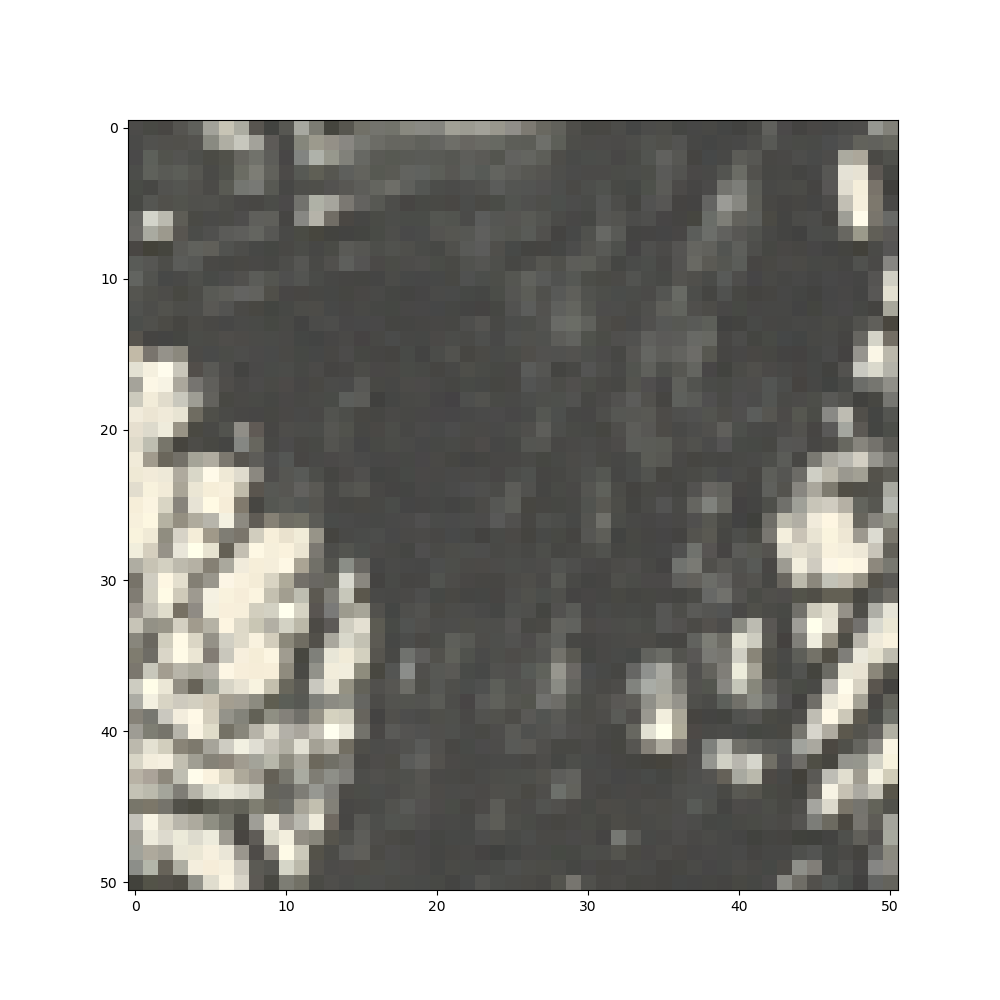

<IPython.core.display.Javascript object>


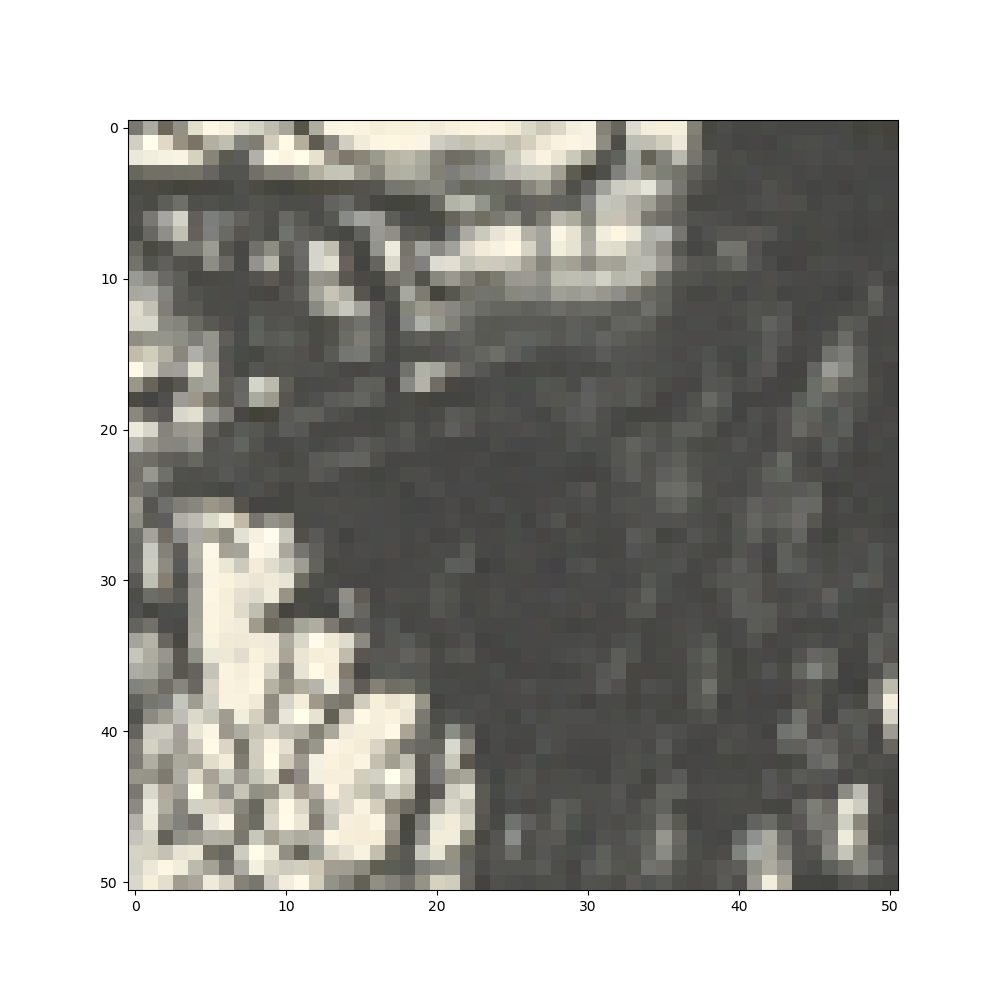

<IPython.core.display.Javascript object>


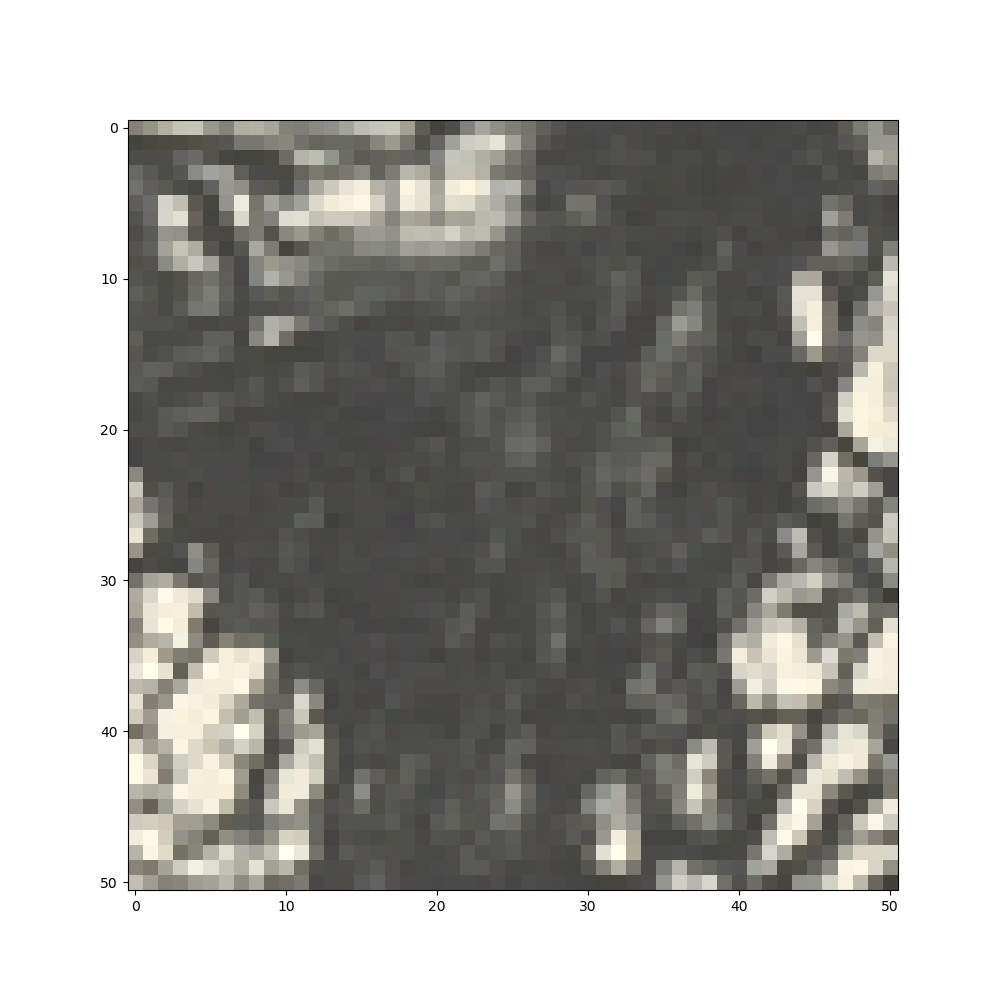

array([[[ 97,  95,  92],
        [ 91,  89,  84],
        [ 76,  77,  72],
        ..., 
        [ 98,  99,  95],
        [ 94,  92,  87],
        [106, 103,  99]],

       [[107, 107, 103],
        [212, 212, 202],
        [193, 189, 175],
        ..., 
        [ 76,  76,  72],
        [ 70,  69,  66],
        [130, 130, 125]],

       [[105, 104, 100],
        [214, 213, 203],
        [226, 224, 208],
        ..., 
        [ 77,  78,  76],
        [ 73,  72,  70],
        [114, 113, 108]],

       ..., 
       [[181, 179, 168],
        [223, 222, 208],
        [235, 233, 219],
        ..., 
        [ 99,  99,  95],
        [ 92,  93,  88],
        [ 99,  97,  90]],

       [[ 75,  74,  65],
        [ 91,  91,  81],
        [105, 104,  94],
        ..., 
        [ 98,  97,  91],
        [115, 113, 107],
        [170, 168, 158]],

       [[173, 170, 158],
        [143, 143, 131],
        [118, 118, 108],
        ..., 
        [ 90,  89,  83],
        [178, 180, 172],
        [211, 210,

In [149]:
choose_sample_test(50,ssd,51,sample)